In [4]:
# Activation Patching Experiments
# Minimal pair patching to identify directional update circuits

import torch
import pandas as pd
from utils.grid_utils import *
from utils.model_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000"
model, tokenizer = load_model_and_tokenizer(MODEL_PATH)

def generate_minimal_pair_case():
    """Generate prompts identical except for final direction."""
    while True:
        G = get_grid_graph(generate_random_names(16), size=4)
        walk = generate_random_walk(G, random.choice(list(G.nodes())), 120)
        
        for i in range(len(walk) - 2, 5, -1):
            node = walk[i]
            successors = list(G.successors(node))
            if len(successors) >= 2:
                base_prompt_walk = walk[:i+1]
                base_prompt_str = walk_to_string(base_prompt_walk, G)
                
                direction1 = G.edges[node, successors[0]]['direction']
                target1 = successors[0]
                direction2 = G.edges[node, successors[1]]['direction']
                target2 = successors[1]
                
                return {
                    "base_prompt": base_prompt_str,
                    "clean_direction": direction1,
                    "clean_prompt": f"{base_prompt_str} {direction1}",
                    "expected_clean_prediction": target1,
                    "corrupt_direction": direction2,
                    "corrupt_prompt": f"{base_prompt_str} {direction2}",
                    "expected_corrupt_prediction": target2,
                }

def run_patching_experiment(model, tokenizer, test_case, target_layer, component_type):
    """Run patching experiment for given layer and component."""
    clean_tokens = tokenizer(test_case['clean_prompt'], return_tensors="pt").to(DEVICE)
    corrupt_tokens = tokenizer(test_case['corrupt_prompt'], return_tensors="pt").to(DEVICE)
    
    clean_direction_pos = find_token_position(clean_tokens, test_case['clean_direction'], tokenizer)
    corrupt_direction_pos = find_token_position(corrupt_tokens, test_case['corrupt_direction'], tokenizer)
    
    # Get patch vector
    cache = {}
    def capture_hook(_, __, output):
        if component_type == 'attention':
            cache['output'] = output[0][0, corrupt_direction_pos, :].detach()
        else:
            cache['output'] = output[0, corrupt_direction_pos, :].detach()
    
    target_module = model.transformer.h[target_layer].attn if component_type == 'attention' else model.transformer.h[target_layer].mlp
    hook = target_module.register_forward_hook(capture_hook)
    with torch.no_grad():
        model(**corrupt_tokens)
    hook.remove()
    patch_vector = cache['output']
    
    # Run patched experiment
    with ComponentPatcher(model, target_layer, component_type, patch_vector, clean_direction_pos):
        with torch.no_grad():
            patched_outputs = model(**clean_tokens)
    
    patched_logits = patched_outputs.logits[0, clean_direction_pos, :]
    predicted_id = torch.argmax(patched_logits).item()
    predicted_token = tokenizer.decode(predicted_id).strip()
    
    return predicted_token

def run_systematic_patching():
    """Run patching across all layers for both MLP and attention."""
    test_case = generate_minimal_pair_case()
    results = []
    
    for layer_idx in range(model.config.n_layer):
        for component in ['mlp', 'attention']:
            try:
                pred = run_patching_experiment(model, tokenizer, test_case, layer_idx, component)
                success = pred == test_case['expected_corrupt_prediction']
                results.append({
                    'Layer': layer_idx,
                    'Component': component,
                    'Prediction': pred,
                    'Success': success
                })
            except Exception as e:
                results.append({
                    'Layer': layer_idx,
                    'Component': component,
                    'Prediction': 'ERROR',
                    'Success': False
                })
    
    return pd.DataFrame(results)


In [5]:
# Run experiments
print("Running systematic patching...")
systematic_results = run_systematic_patching()
print(systematic_results)

Running systematic patching...
    Layer  Component Prediction  Success
0       0        mlp         sa    False
1       0  attention         gh     True
2       1        mlp         sa    False
3       1  attention         sa    False
4       2        mlp         sa    False
5       2  attention         sa    False
6       3        mlp         sa    False
7       3  attention         sa    False
8       4        mlp         sa    False
9       4  attention         sa    False
10      5        mlp         sa    False
11      5  attention         sa    False
12      6        mlp         sa    False
13      6  attention         sa    False
14      7        mlp         sa    False
15      7  attention         sa    False
16      8        mlp         sa    False
17      8  attention         sa    False
18      9        mlp         sa    False
19      9  attention         sa    False
20     10        mlp         sa    False
21     10  attention         sa    False
22     11        mlp      

Running Trials: 100%|██████████| 1000/1000 [00:13<00:00, 72.18it/s]



--- SUMMARY (N=1000 trials) ---
Final Tally of Outcomes:
  Recipient moves in donor direction: 967 / 1000 times (96.7%)
  Recipient copies donor destination:        18 / 1000 times (1.8%)
  Other Result:                              15 / 1000 times (1.5%)



/tmp/ipykernel_210836/3486841141.py:181: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=9, color="black", fontstyle='italic', fontweight='heavy')  # reduce from default 12–14 to 10


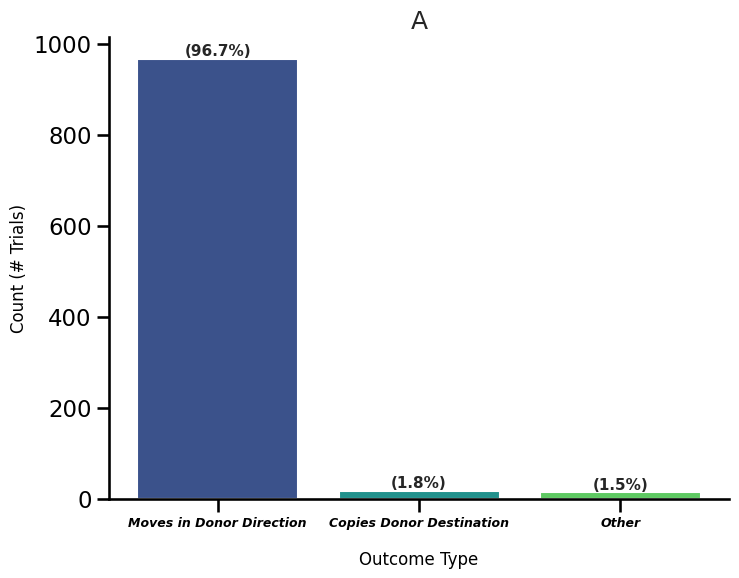

In [9]:
# cross context patching experiment

def generate_independent_test_case():
    """
    Generates cross-context test cases with final direction tokens.
    Ensures donor and recipient have different directions for meaningful patching.
    """
    max_attempts = 100
    
    for attempt in range(max_attempts):
        try:
            # Generate two independent contexts
            G_A = get_grid_graph(generate_random_names(16), size=4)
            walk_A = generate_random_walk(G_A, random.choice(list(G_A.nodes())), 120)
            
            # Use the FINAL direction token for context A
            final_node_A = walk_A[-1]
            neighbors_A = list(G_A.successors(final_node_A))
            if len(neighbors_A) < 2:
                continue
            
            direction_A = G_A.edges[final_node_A, neighbors_A[0]]['direction']
            target_A = neighbors_A[0]
            prompt_A = walk_to_string(walk_A, G_A) + f" {direction_A}"

            G_B = get_grid_graph(generate_random_names(16), size=4)
            walk_B = generate_random_walk(G_B, random.choice(list(G_B.nodes())), 120)
            
            # Use the FINAL direction token for context B
            final_node_B = walk_B[-1]
            neighbors_B = list(G_B.successors(final_node_B))
            if len(neighbors_B) < 2:
                continue
            
            direction_B = G_B.edges[final_node_B, neighbors_B[0]]['direction']
            target_B = neighbors_B[0]
            prompt_B = walk_to_string(walk_B, G_B) + f" {direction_B}"

            # Ensure directions are different
            if direction_A == direction_B:
                continue
            
            # Find expected universal outcome (move in donor direction from recipient)
            expected_outcome_A = None
            for neighbor in G_B.successors(final_node_B):
                if G_B.edges[final_node_B, neighbor]['direction'] == direction_A:
                    expected_outcome_A = neighbor
                    break
            
            # Validate the test case
            if (expected_outcome_A is not None and 
                expected_outcome_A != target_B and 
                expected_outcome_A != target_A):
                
                return {
                    "prompt_A": prompt_A,
                    "direction_A": direction_A,
                    "node_A_end": target_A,
                    "prompt_B": prompt_B,
                    "direction_B": direction_B,
                    "node_B_end": target_B,
                    "expected_outcome_A": expected_outcome_A,  # Universal: move in donor direction
                    "expected_outcome_B": target_A,            # Resolved: copy donor's target
                }
            
        except Exception as e:
            continue
    
    raise ValueError(f"Failed to generate valid test case after {max_attempts} attempts")

def cross_context_patching(model, tokenizer, num_runs=1000):
    """
    Runs the universal vector experiment many times to get a statistical measure of behavior.
    """

    outcomes = {'A': 0, 'B': 0, 'Unexpected': 0}

    for i in tqdm(range(num_runs), desc="Running Trials"):

        TARGET_LAYER = 0

        try:
            test_case = generate_independent_test_case()
        except (RecursionError, TypeError, ValueError) as e:
            print(f"Test case generation failed: {e}")
            continue

        # 1. Get Patch Vector from Donor A
        tokens_A = tokenizer(test_case["prompt_A"], return_tensors="pt").to(DEVICE)
        pos_A = find_token_position(tokens_A, test_case["direction_A"], tokenizer)

        attn_outputs_cache = []
        target_attn_module = model.transformer.h[TARGET_LAYER].attn
        def attn_hook(_, __, output): attn_outputs_cache.append(output[0])
        hook = target_attn_module.register_forward_hook(attn_hook)
        with torch.no_grad(): model(**tokens_A)
        hook.remove()

        if not attn_outputs_cache:
            print("Attention hook did not fire, skipping trial.")
            outcomes['Unexpected'] += 1
            continue

        patch_vector = attn_outputs_cache[0][0, pos_A, :].detach()

        # 2. Run Patched Pass on Recipient B
        tokens_B = tokenizer(test_case["prompt_B"], return_tensors="pt").to(DEVICE)
        pos_B = find_token_position(tokens_B, test_case["direction_B"], tokenizer)

        with ComponentPatcher(model, TARGET_LAYER, 'attention', patch_vector, pos_B):
            with torch.no_grad():
                patched_outputs = model(**tokens_B)

        last_token_logits = patched_outputs.logits[0, pos_B, :]
        predicted_token = tokenizer.decode(torch.argmax(last_token_logits).item()).strip()

        # 3. Analyze and store the result for this run
        if predicted_token == test_case['expected_outcome_A']:
            outcomes['A'] += 1
        elif predicted_token == test_case['expected_outcome_B']:
            outcomes['B'] += 1
        else:
            outcomes['Unexpected'] += 1

    # --- Final Summary Across All Runs ---
    print("\n\n" + "="*50)
    print(f"--- SUMMARY (N={num_runs} trials) ---")
    print("="*50)

    total_runs = sum(outcomes.values())

    # Calculate percentages
    percent_A = (outcomes['A'] / total_runs) * 100 if total_runs > 0 else 0
    percent_B = (outcomes['B'] / total_runs) * 100 if total_runs > 0 else 0
    percent_U = (outcomes['Unexpected'] / total_runs) * 100 if total_runs > 0 else 0

    print("Final Tally of Outcomes:")
    print(f"  Recipient moves in donor direction: {outcomes['A']:>3} / {total_runs} times ({percent_A:.1f}%)")
    print(f"  Recipient copies donor destination:       {outcomes['B']:>3} / {total_runs} times ({percent_B:.1f}%)")
    print(f"  Other Result:                             {outcomes['Unexpected']:>3} / {total_runs} times ({percent_U:.1f}%)")

    # --- Axes styling ---
    plt.rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 2,
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "xtick.major.width": 2,
        "ytick.major.width": 2,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
    })

    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # --- Viridis colors ---
    palette = sns.color_palette("viridis", n_colors=3)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))

    labels = [
    "Moves in Donor Direction",
    "Copies Donor Destination",
    "Other"]

    counts = [outcomes['A'], outcomes['B'], outcomes['Unexpected']]
    percentages = [percent_A, percent_B, percent_U]

    bars = ax.bar(labels, counts, color=palette)

    ax.set_ylabel('Count (# Trials)', fontsize=12)
    ax.set_xlabel('Outcome Type', fontsize=12, labelpad=15)
    # Set smaller font size for x-axis labels
    ax.set_xticklabels(labels, fontsize=9, color="black", fontstyle='italic', fontweight='heavy')  # reduce from default 12–14 to 10

    # Add percentages on bars only
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'({percent:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')


    sns.despine()  # remove top/right spines
    plt.title("A")
    plt.show()

# run experiment
cross_context_patching(model, tokenizer, num_runs=1000)


Aggregating data across 1 templates (1000 trials each)...
Total trials to run: 1000

--- Processing Template: 'N-E-S-W' ---


100%|██████████| 1000/1000 [00:03<00:00, 265.67it/s]




============================== PLOTTING AGGREGATED RESULTS ==============================


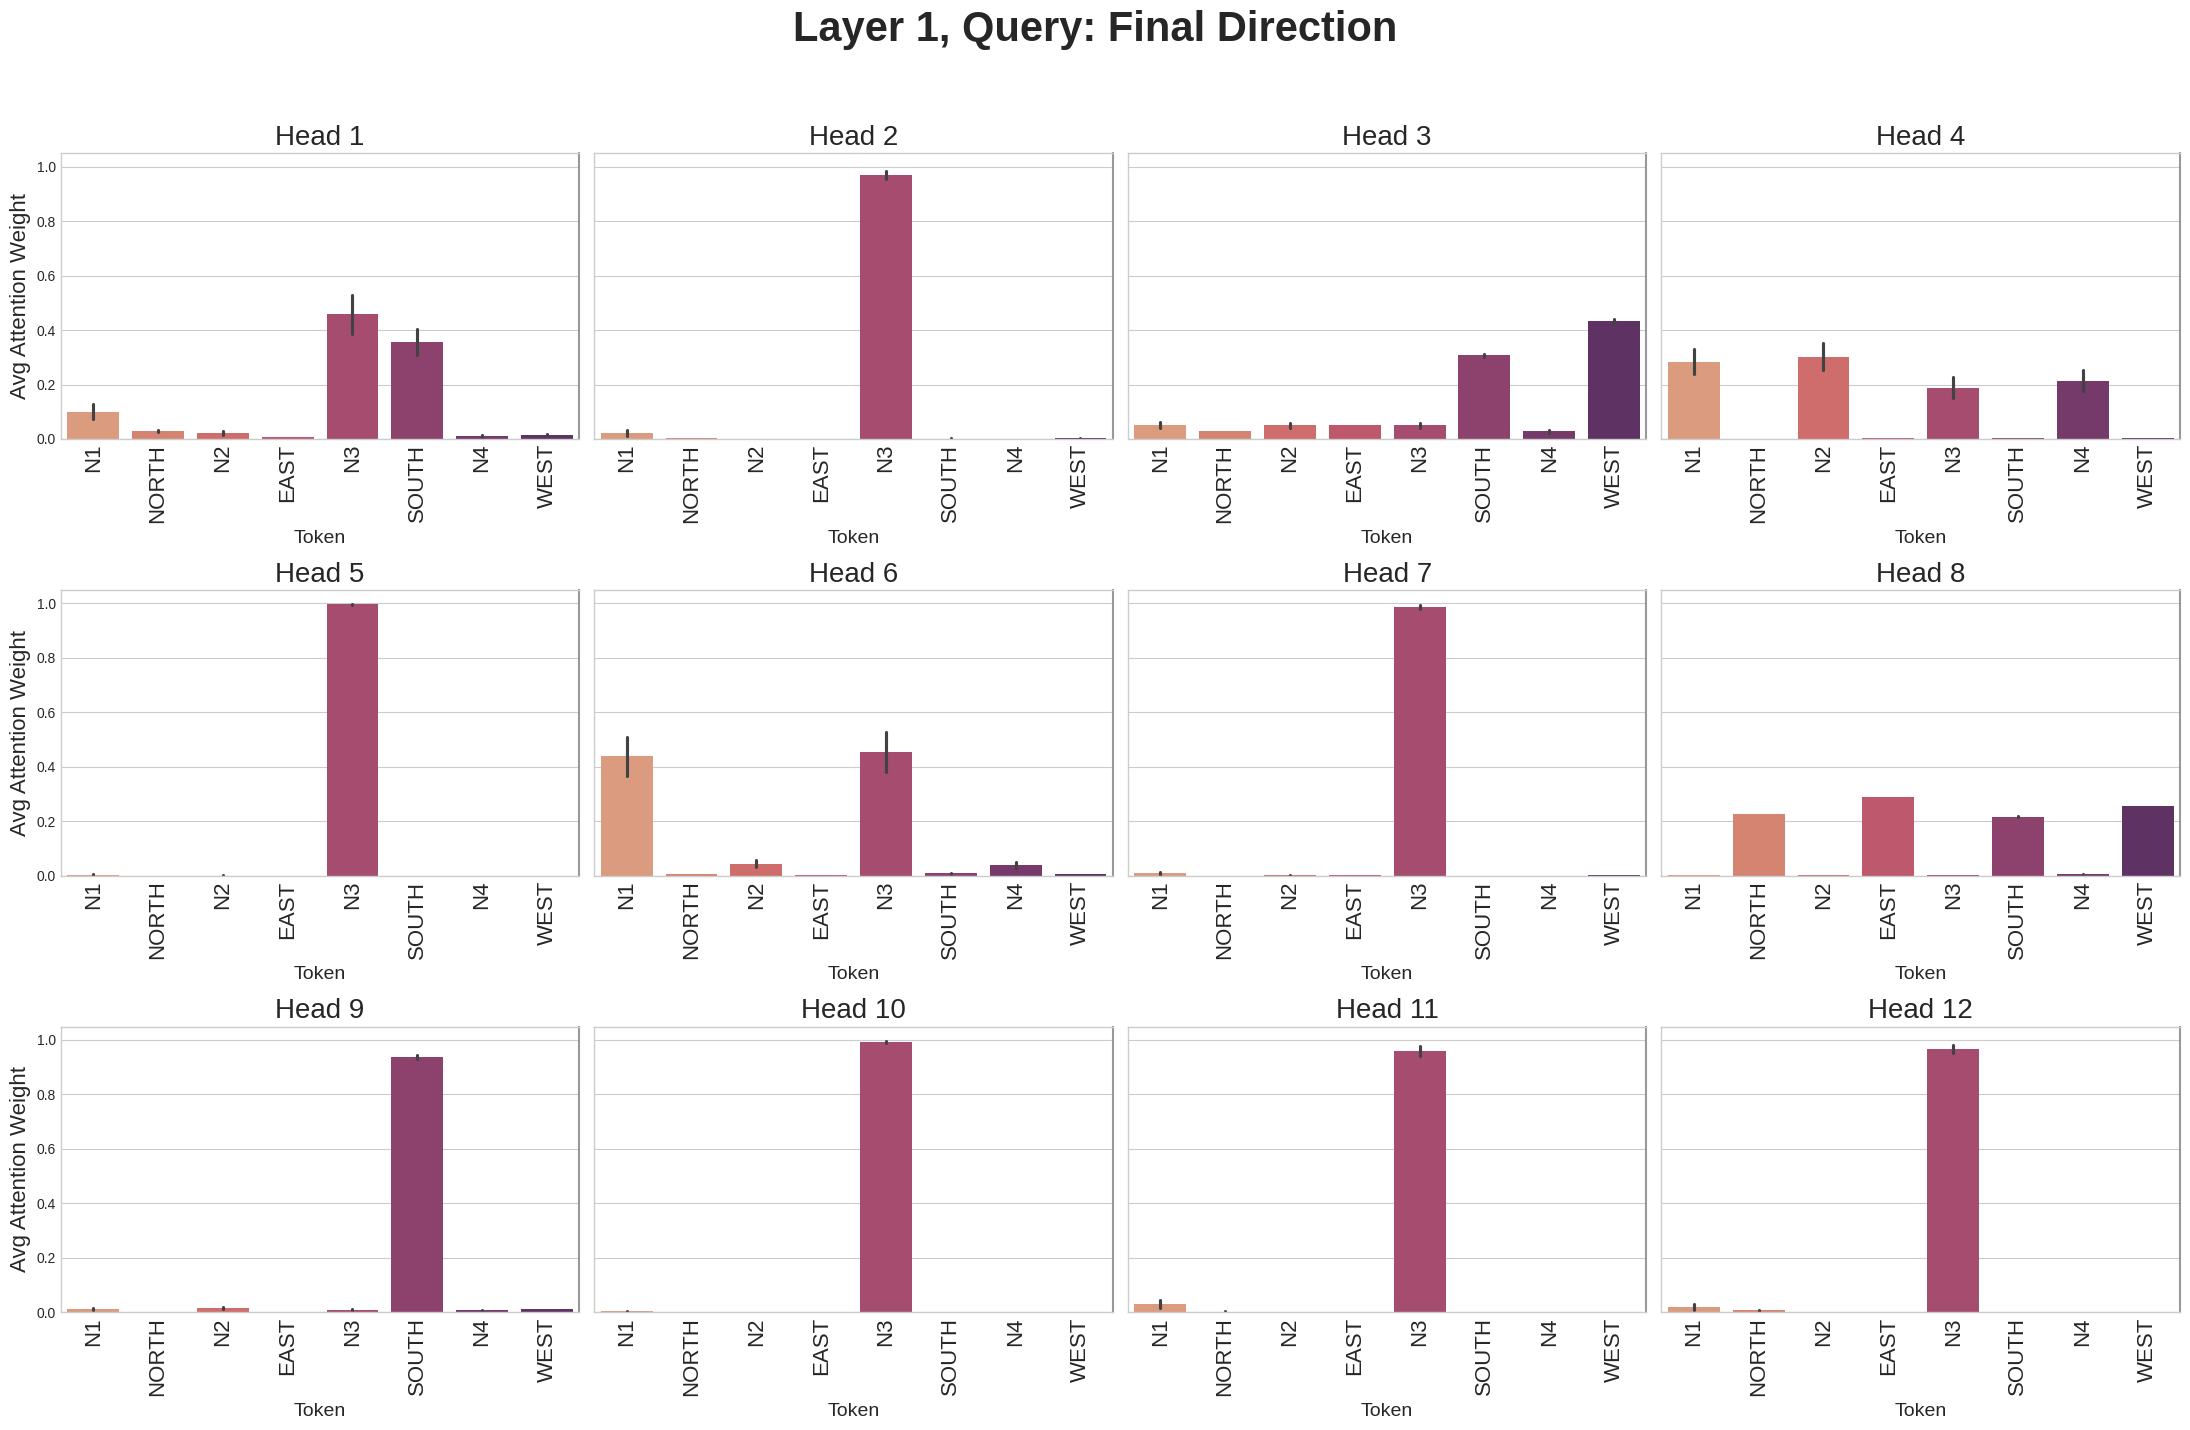

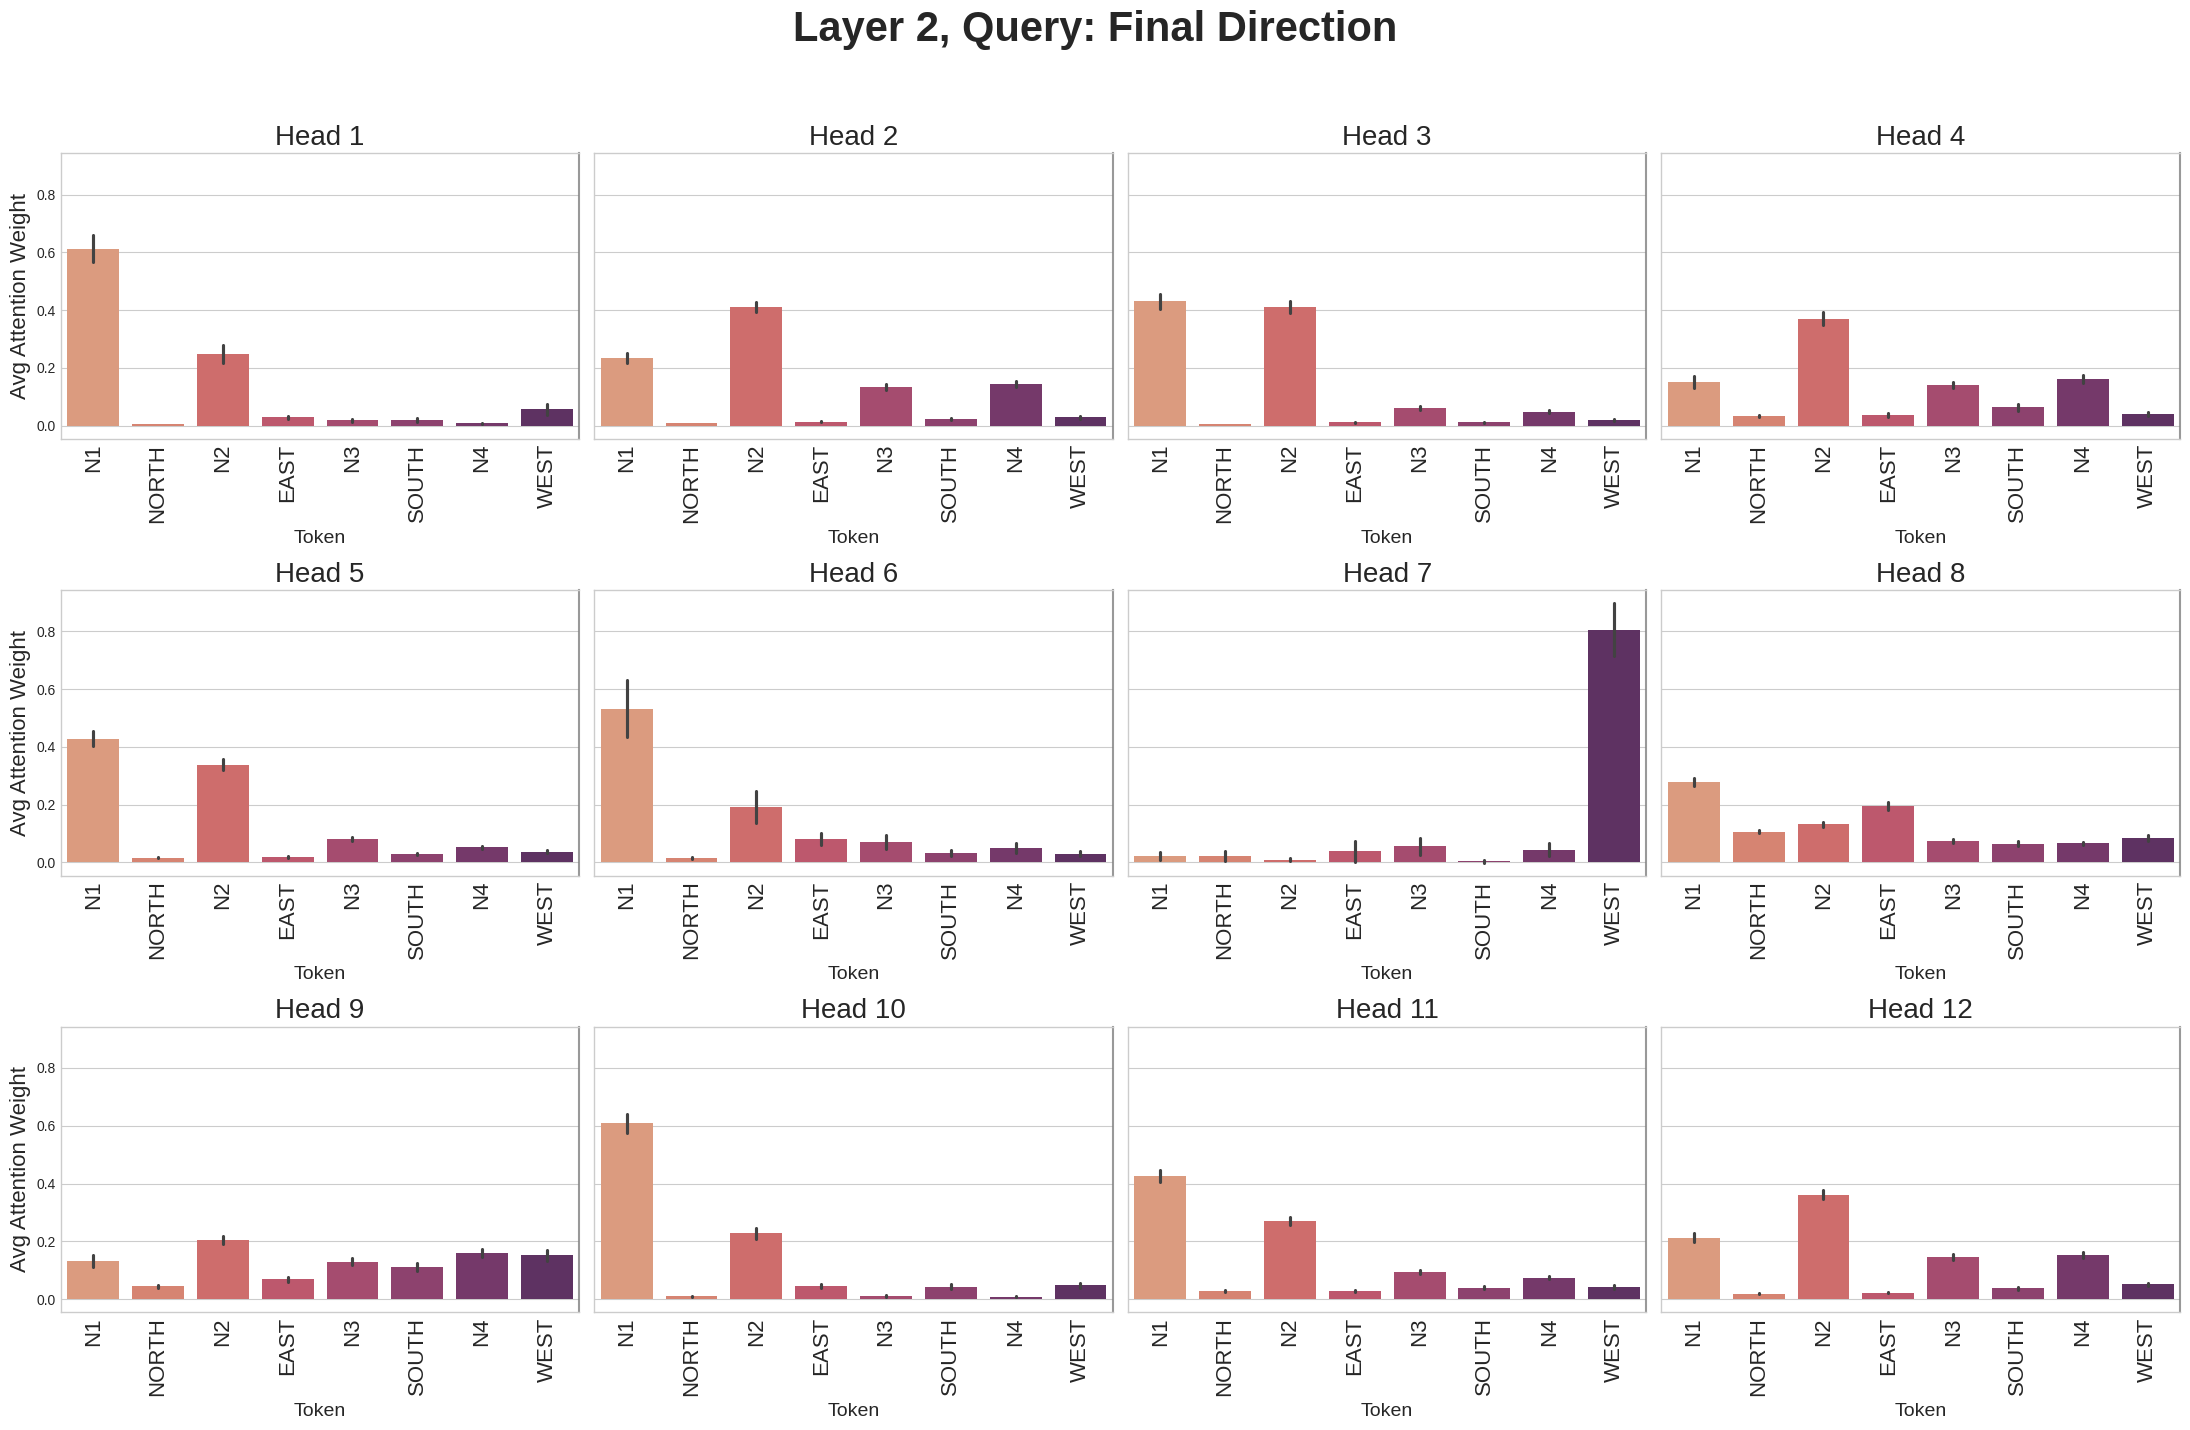

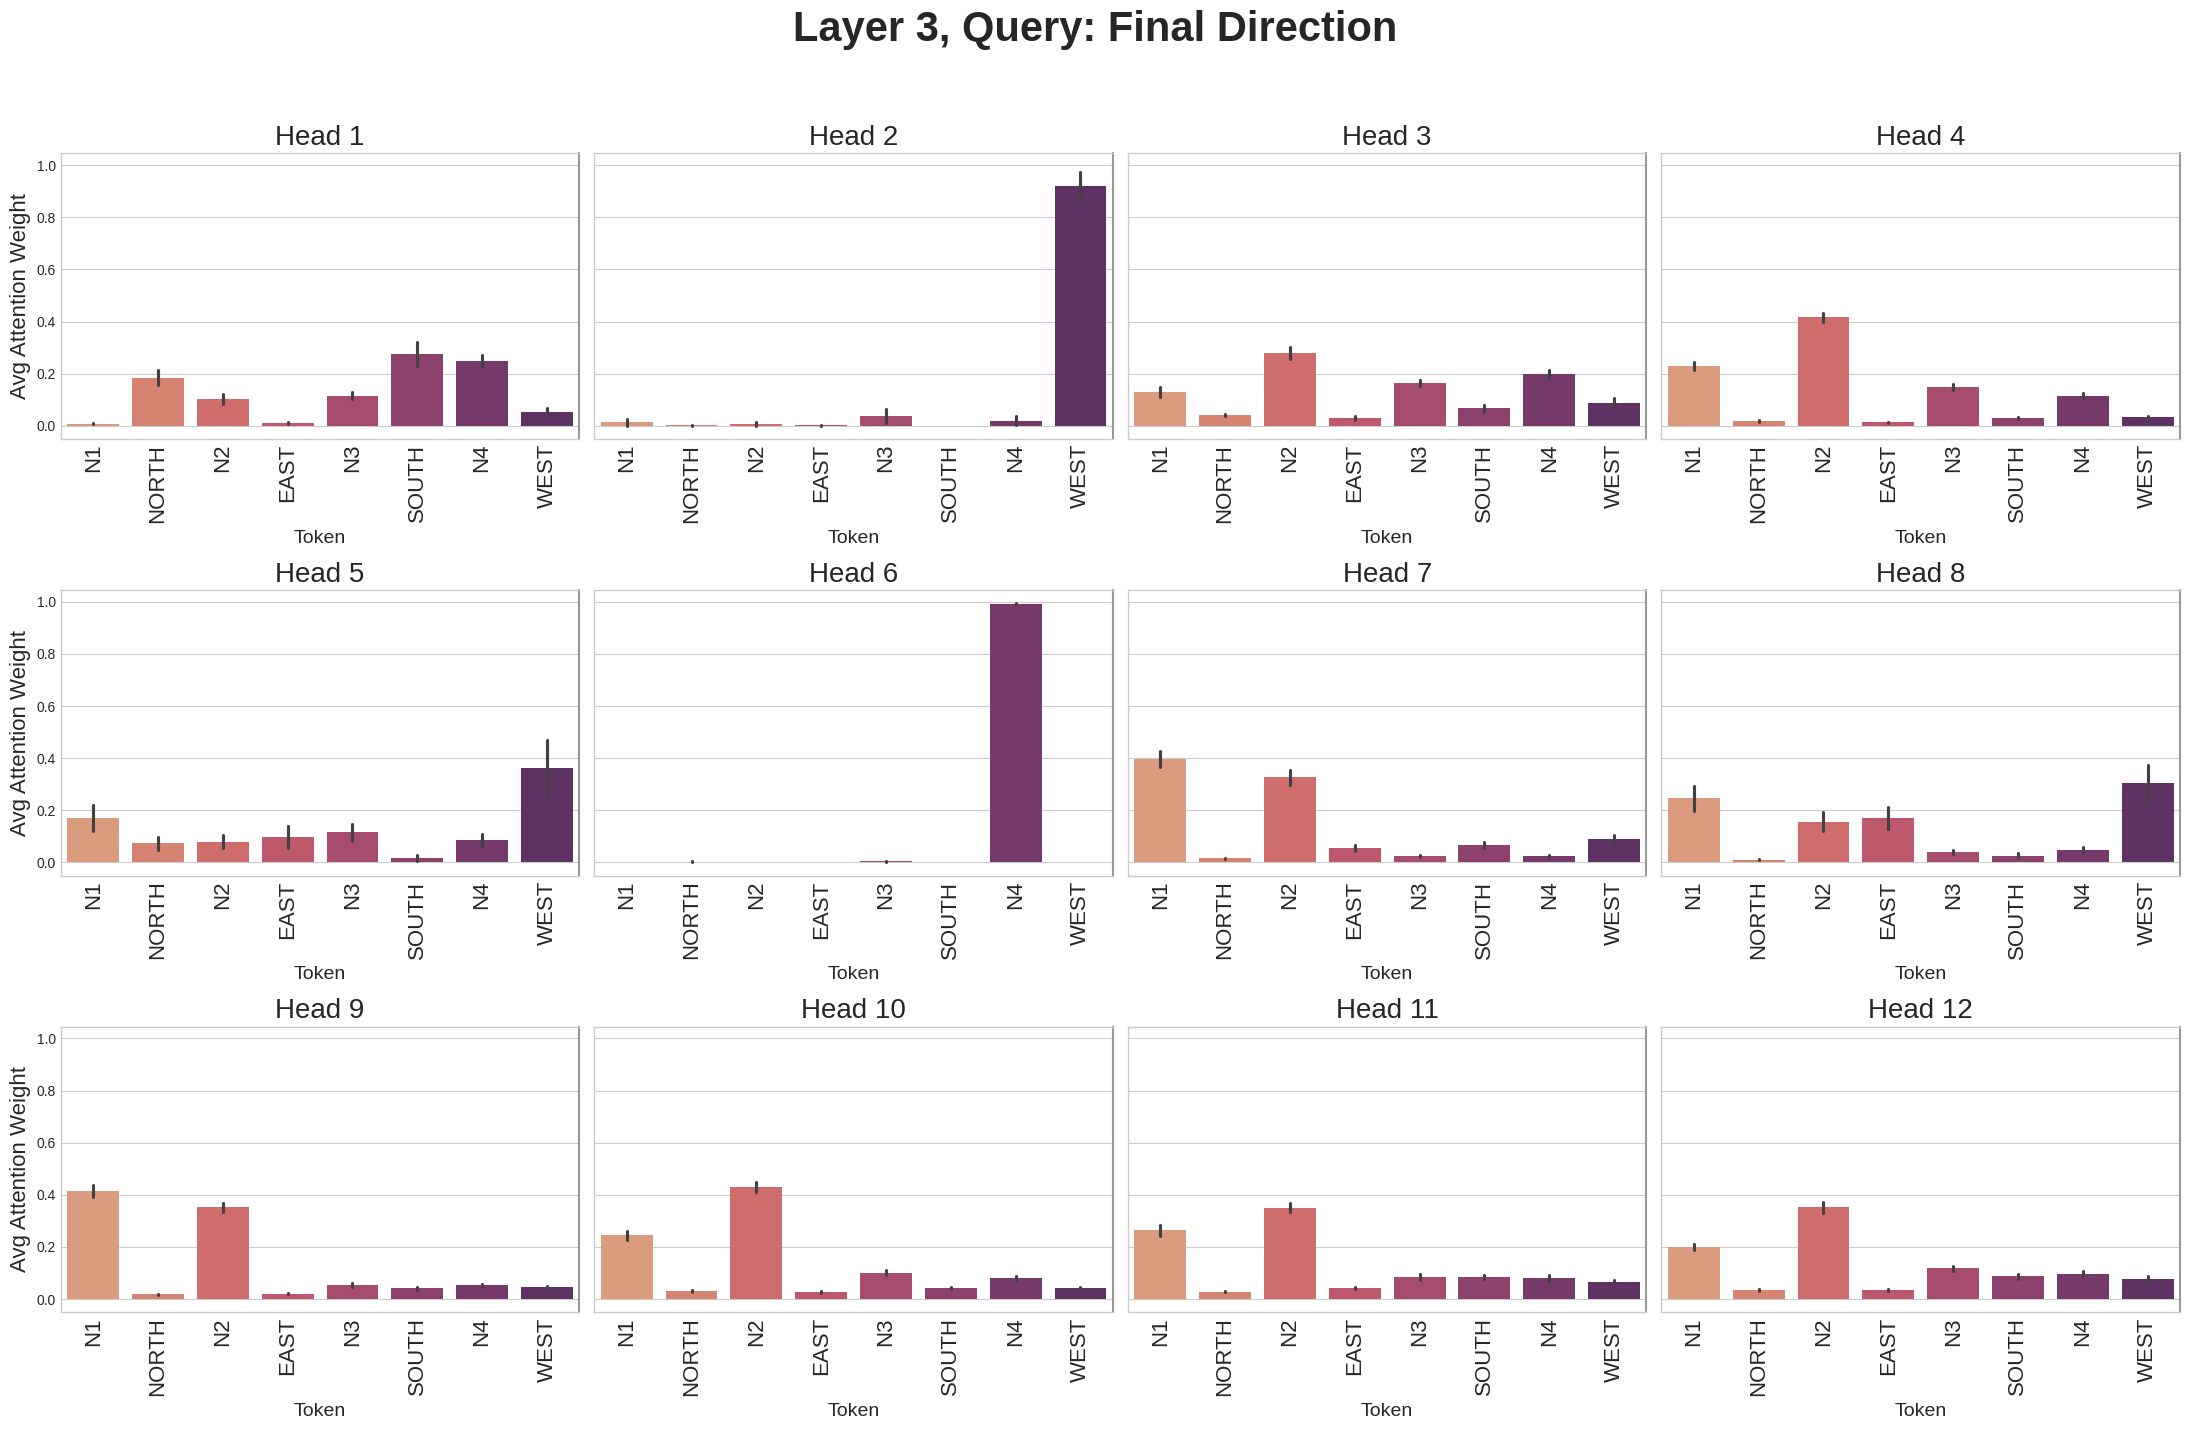

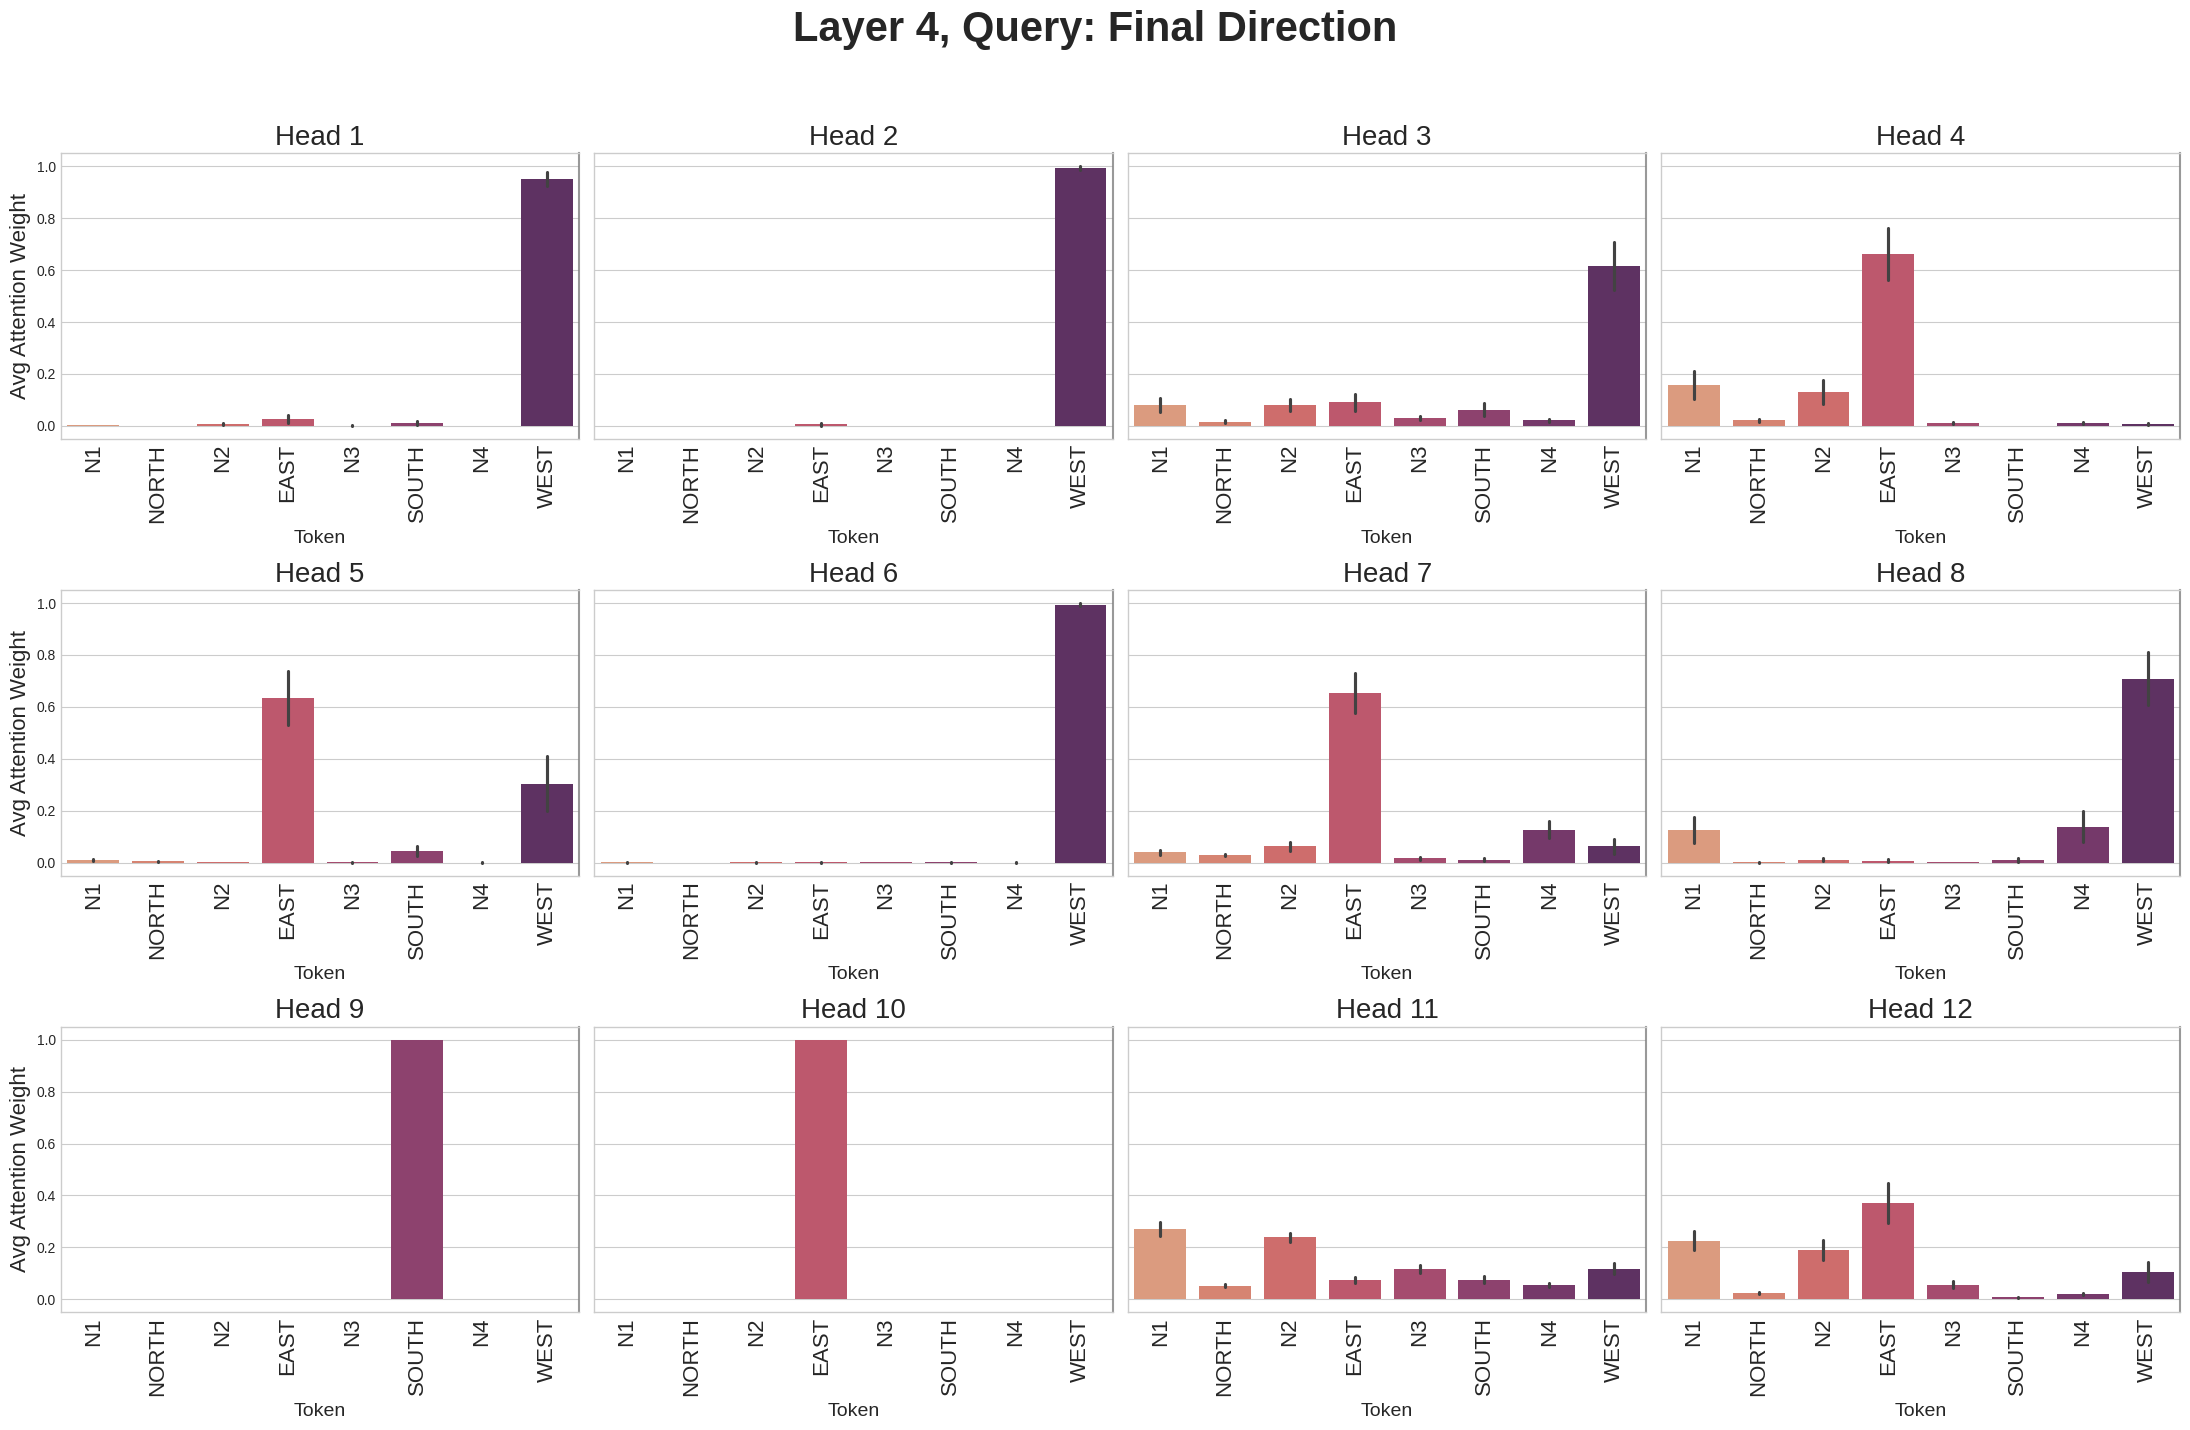

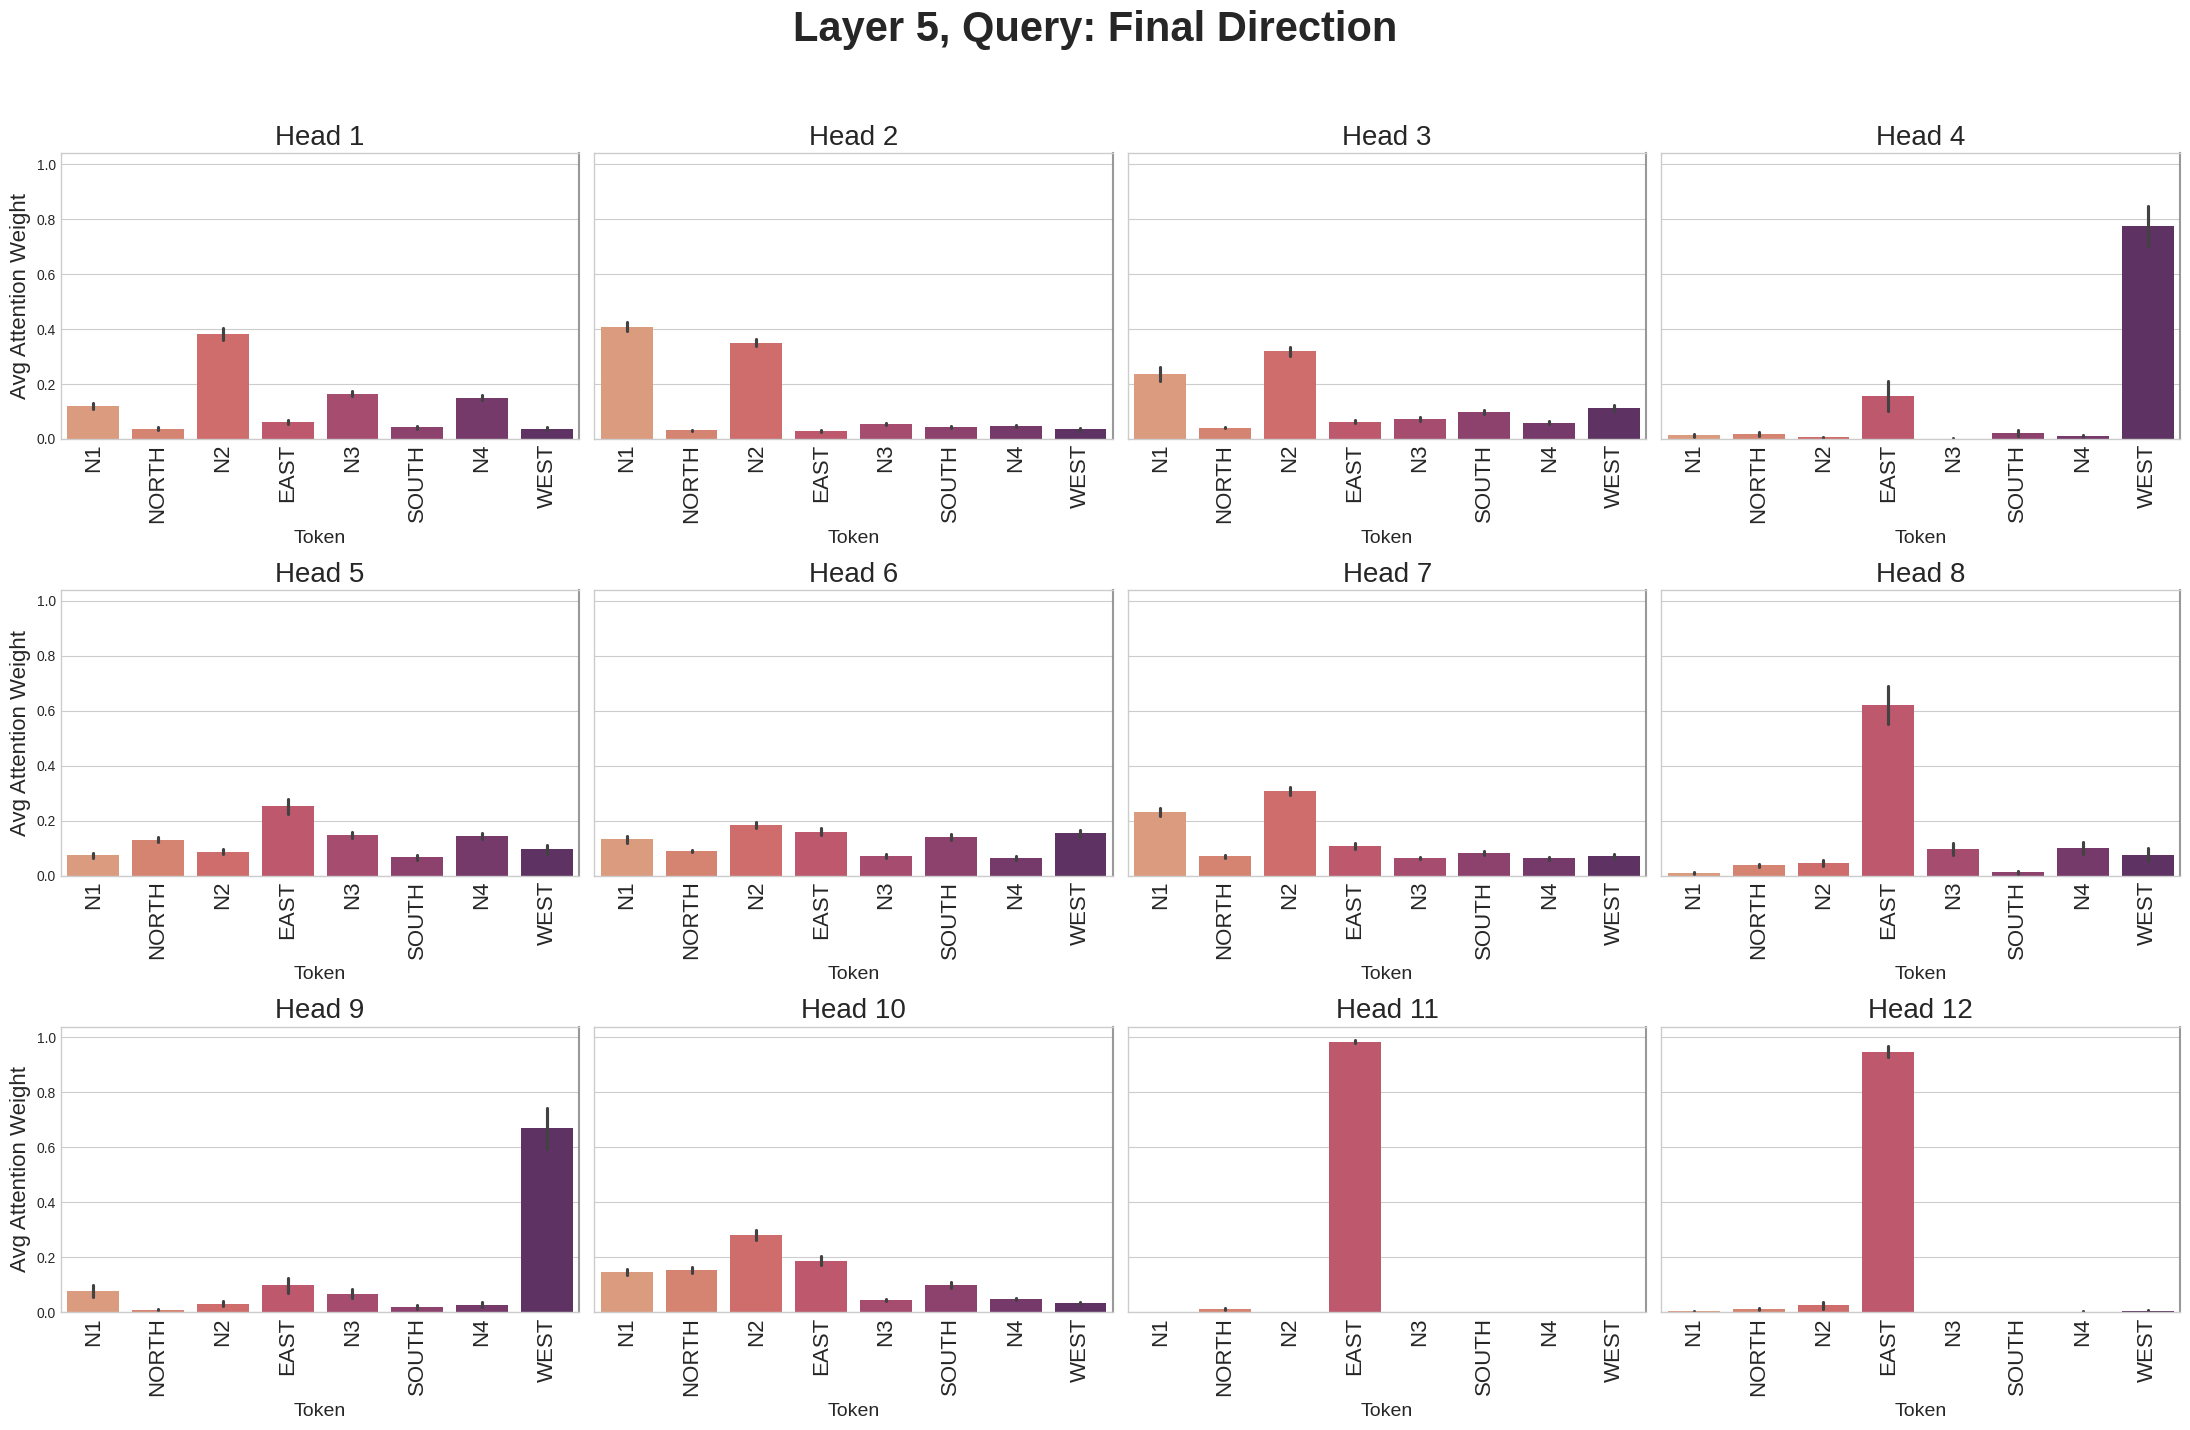

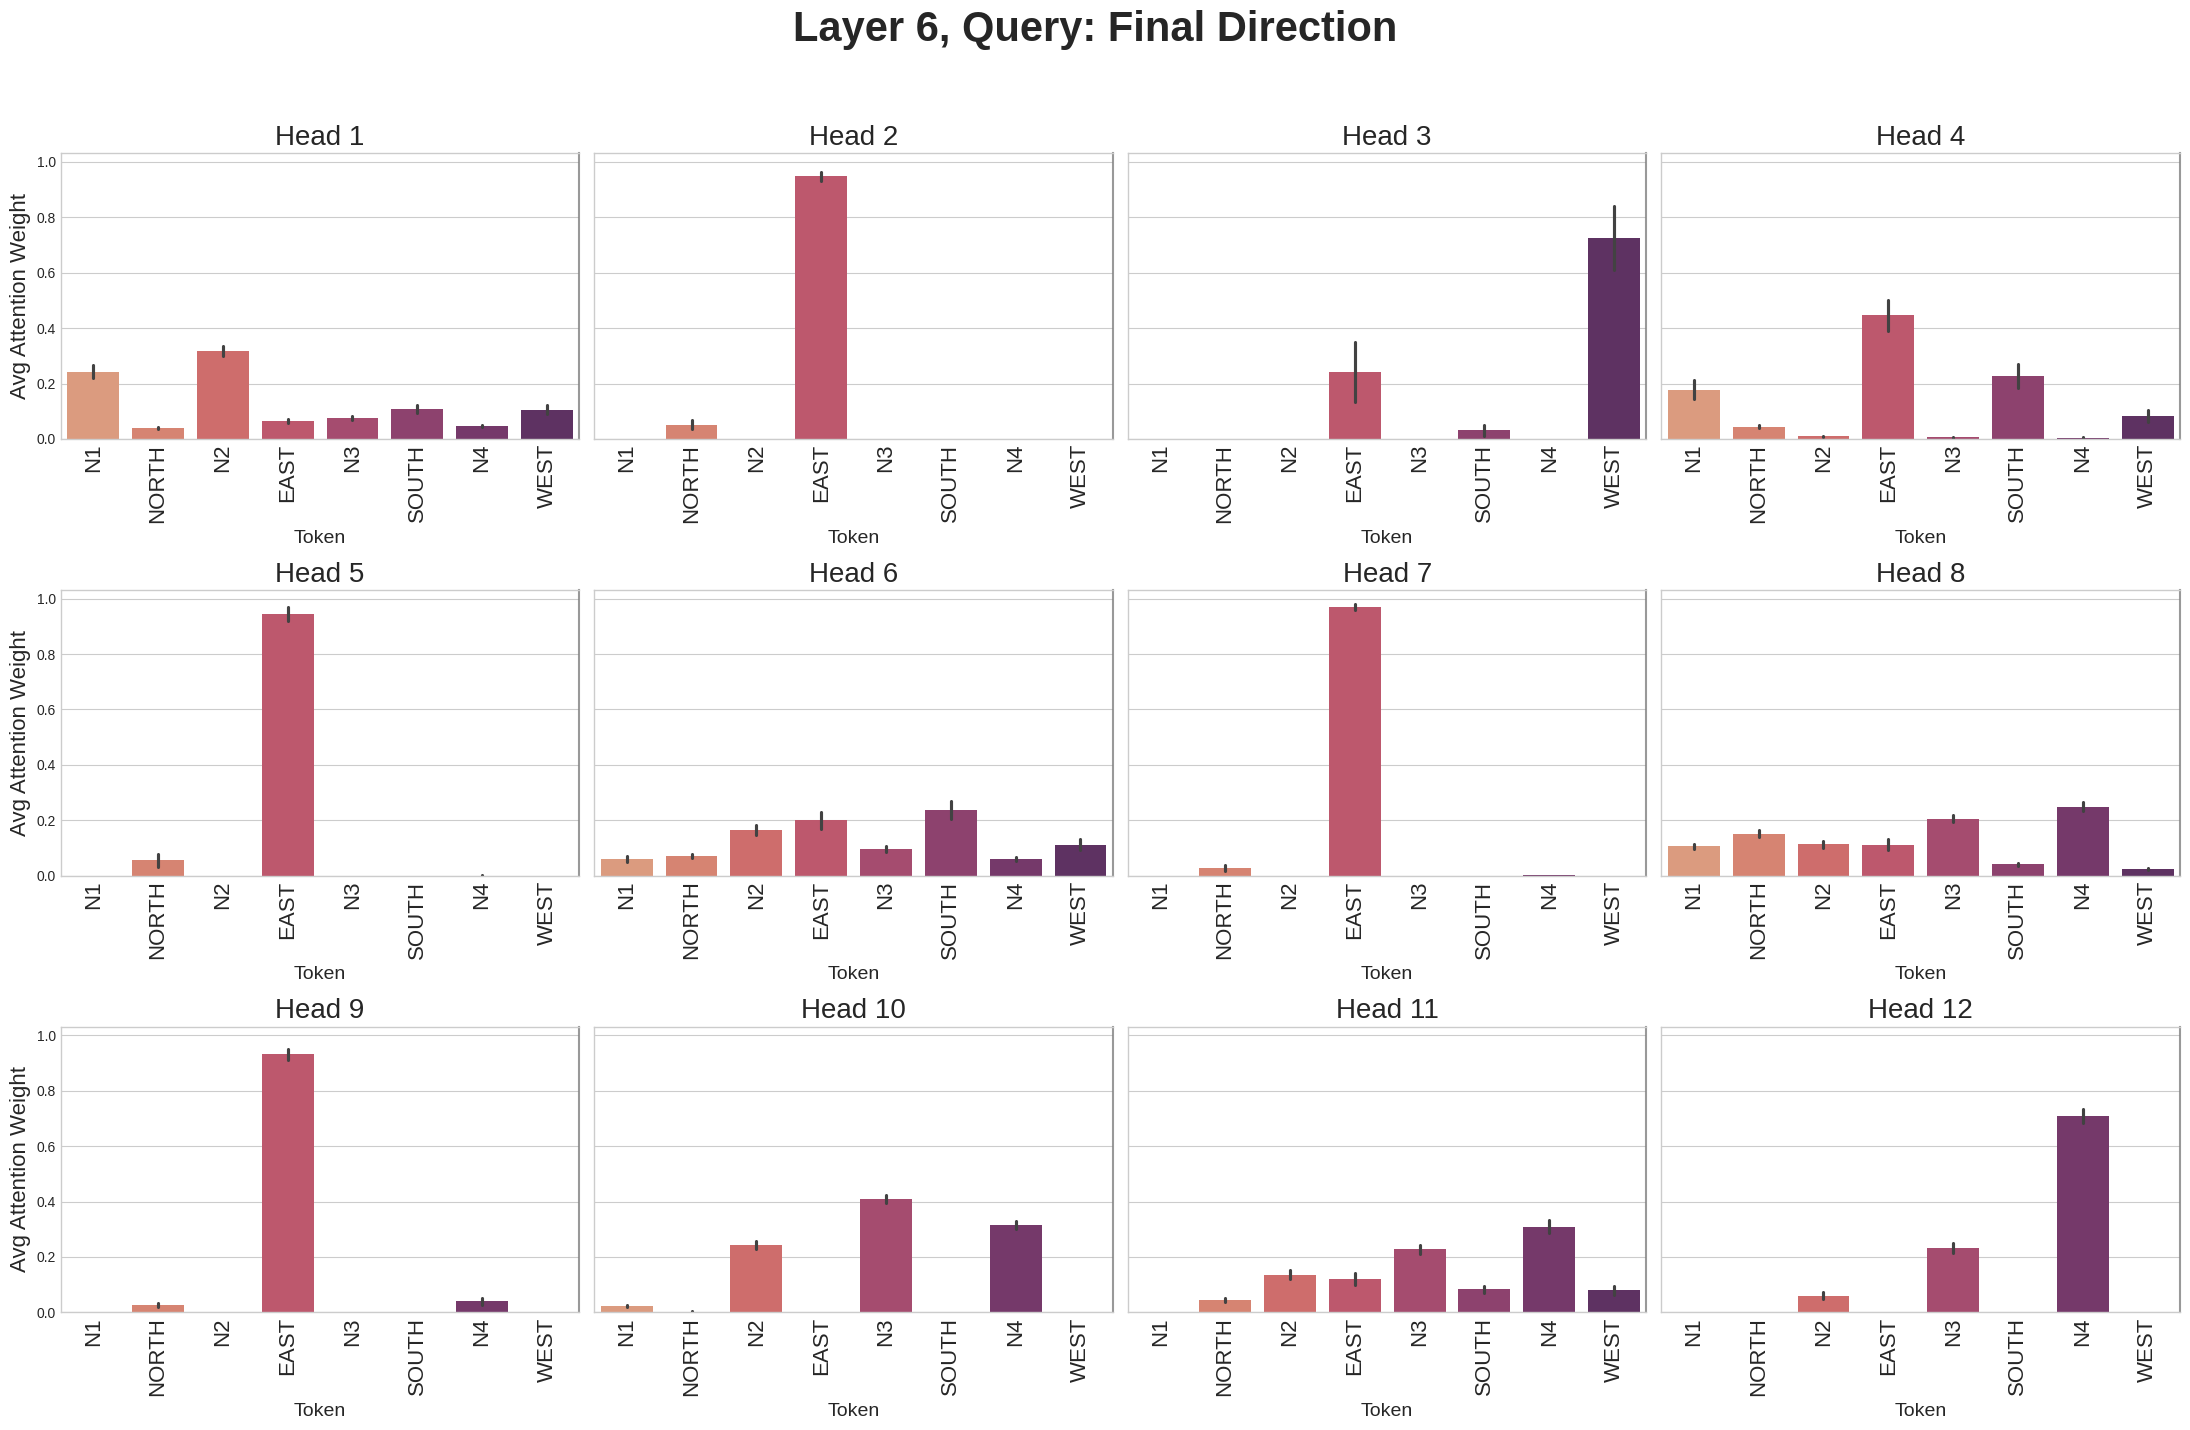

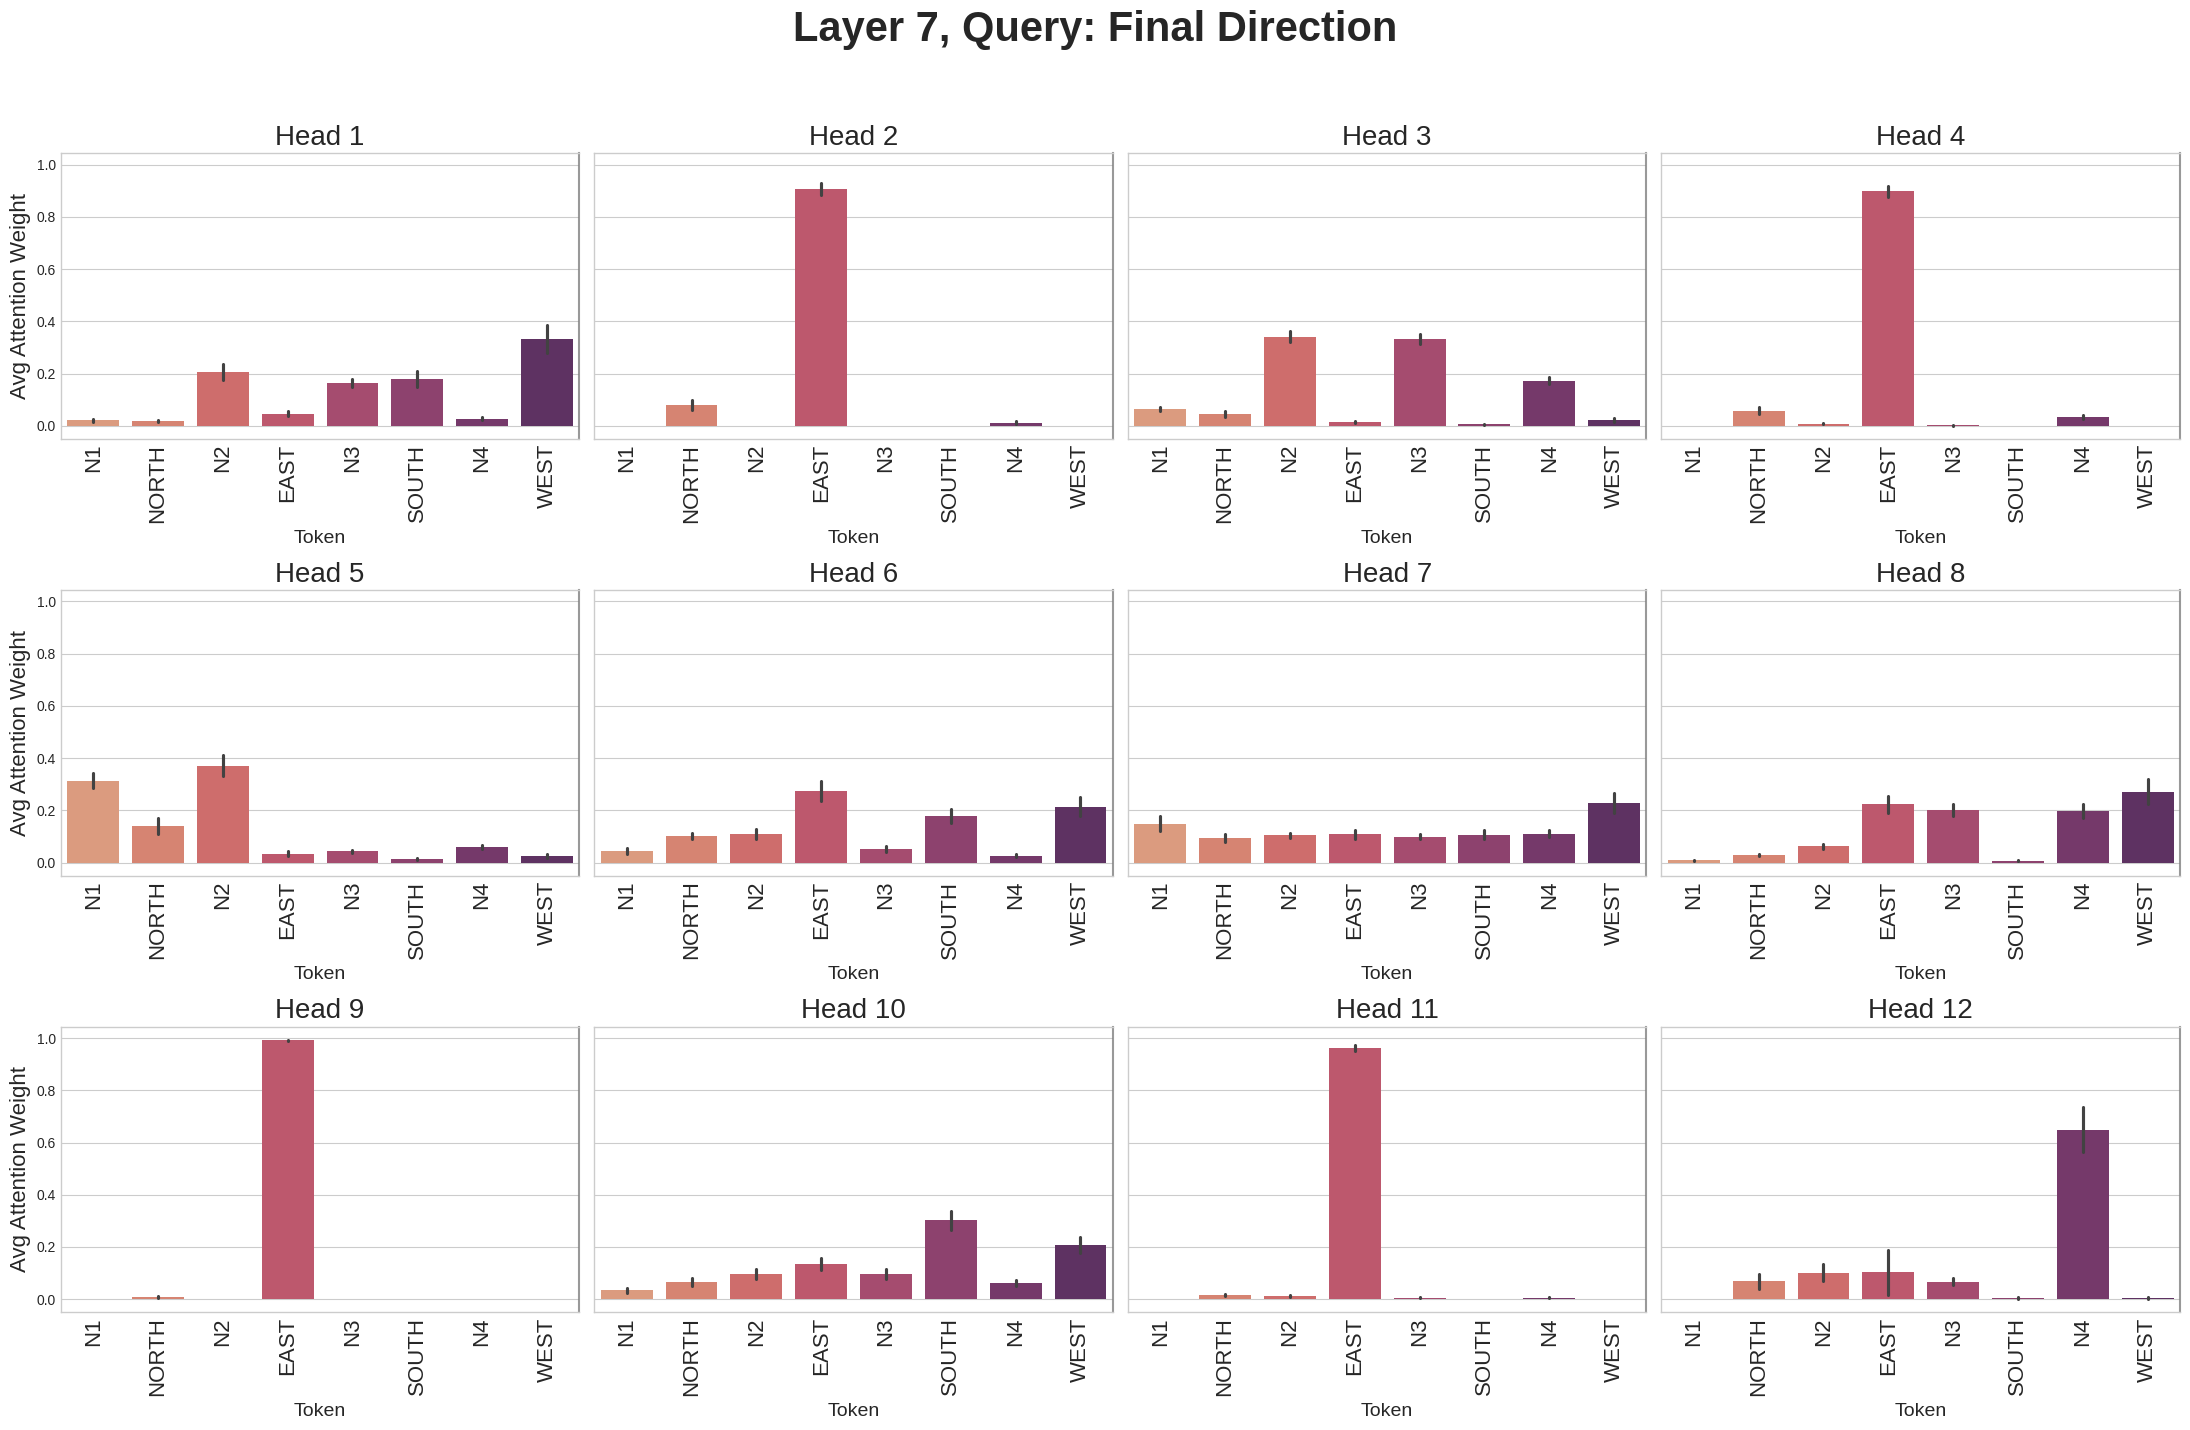

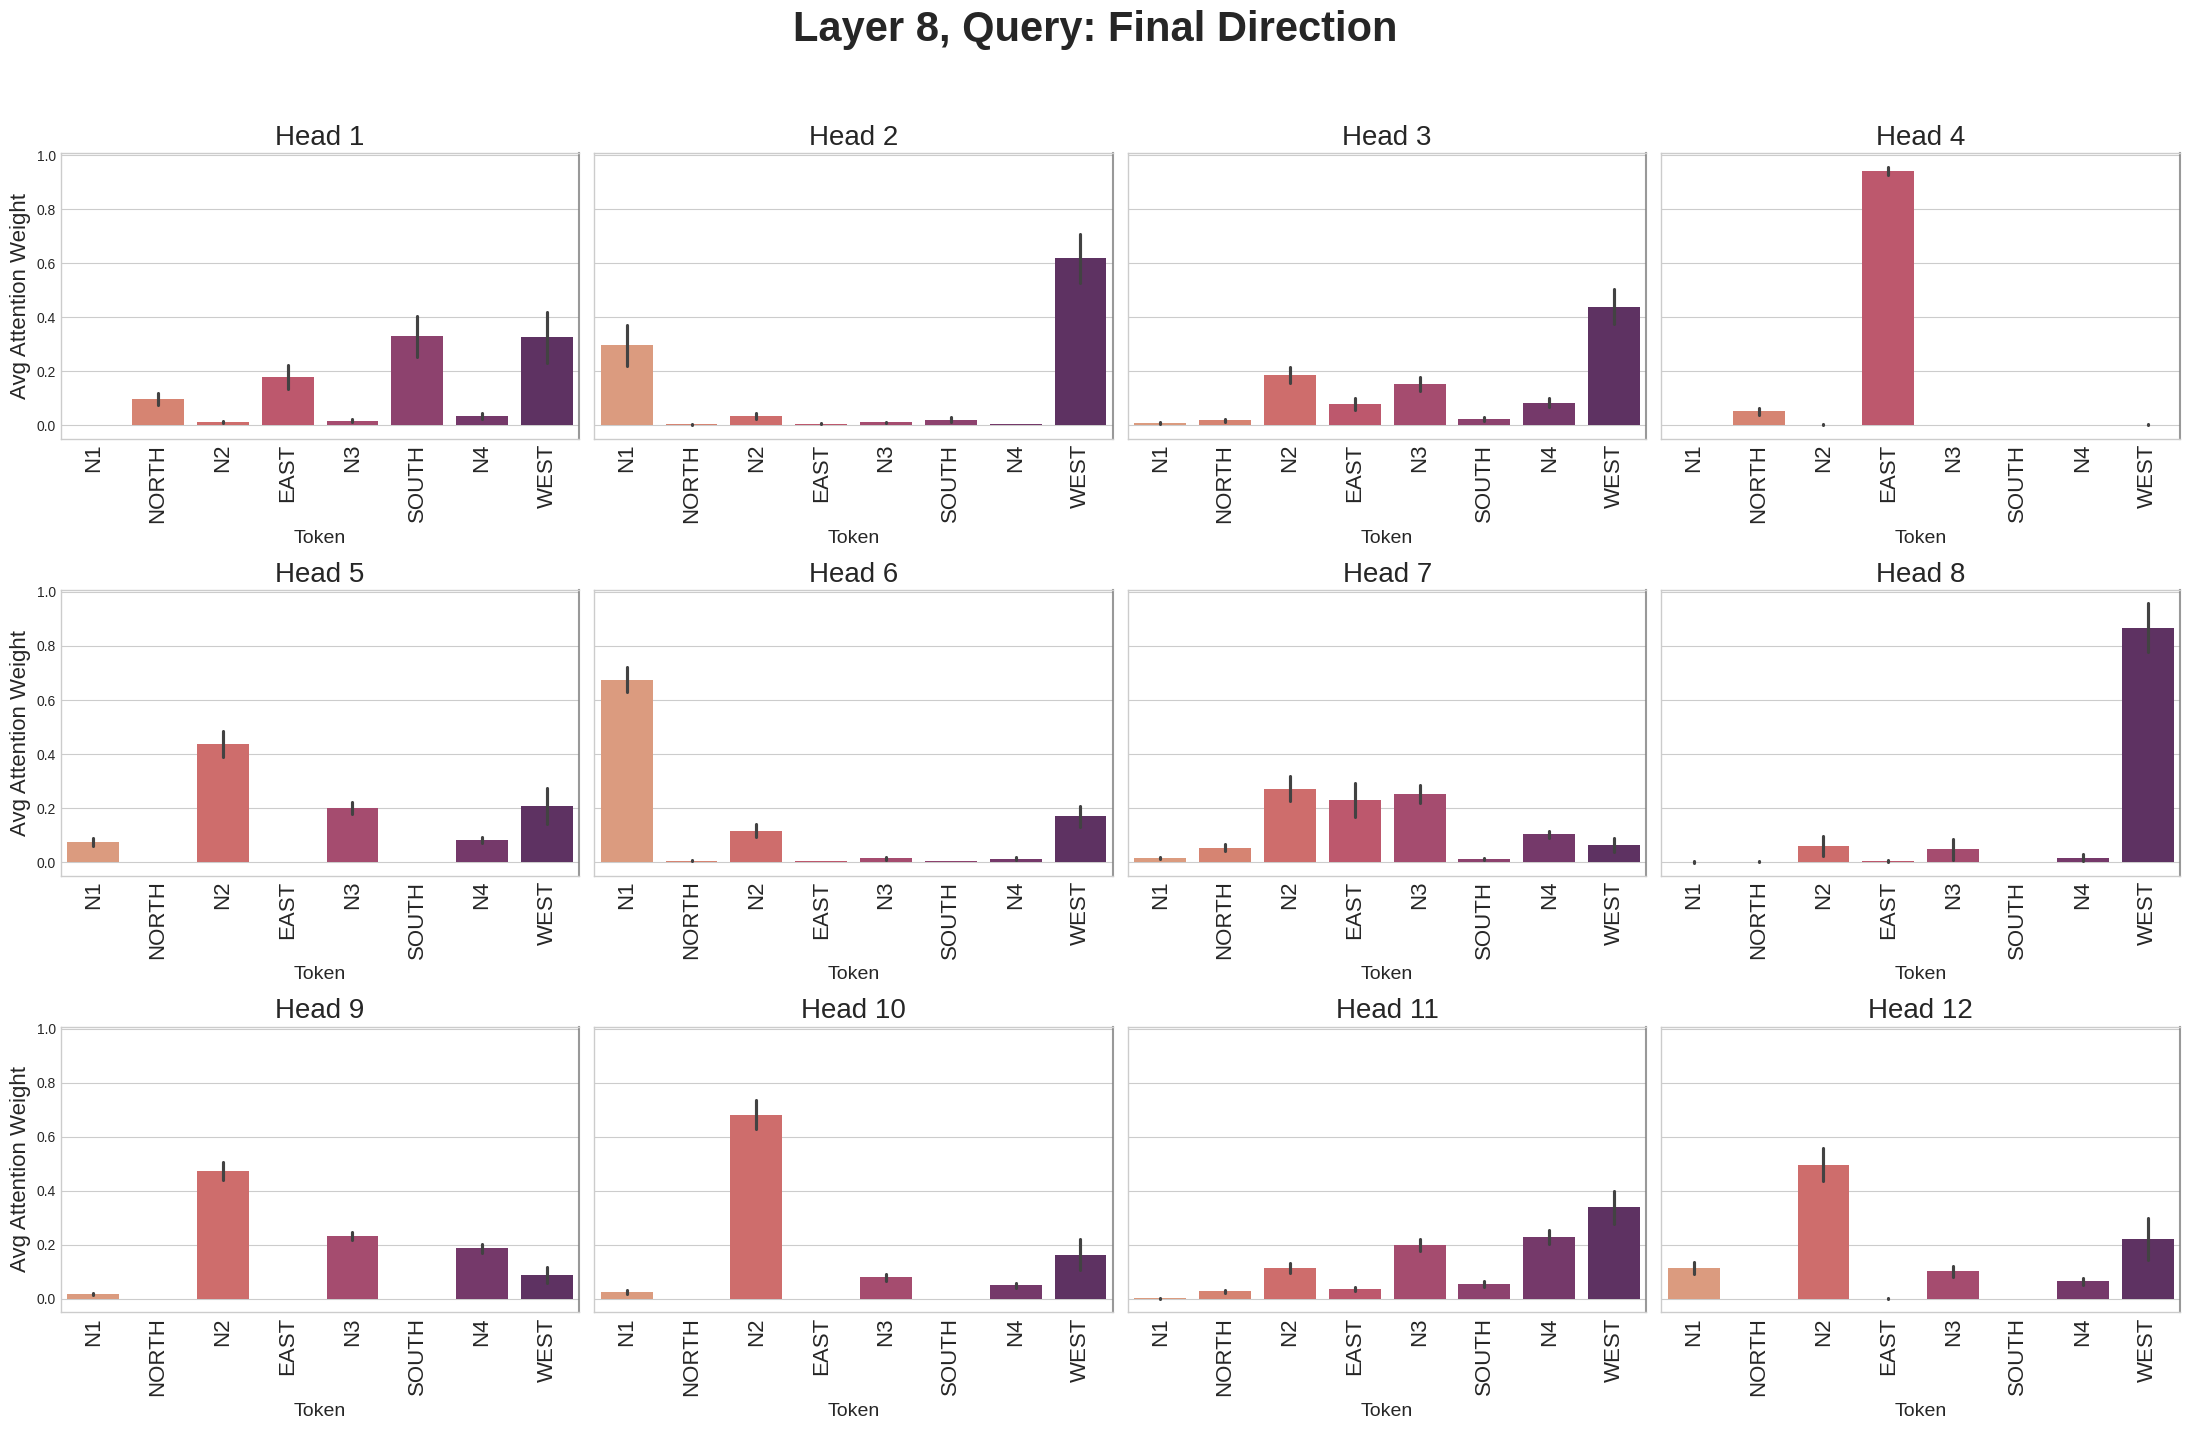

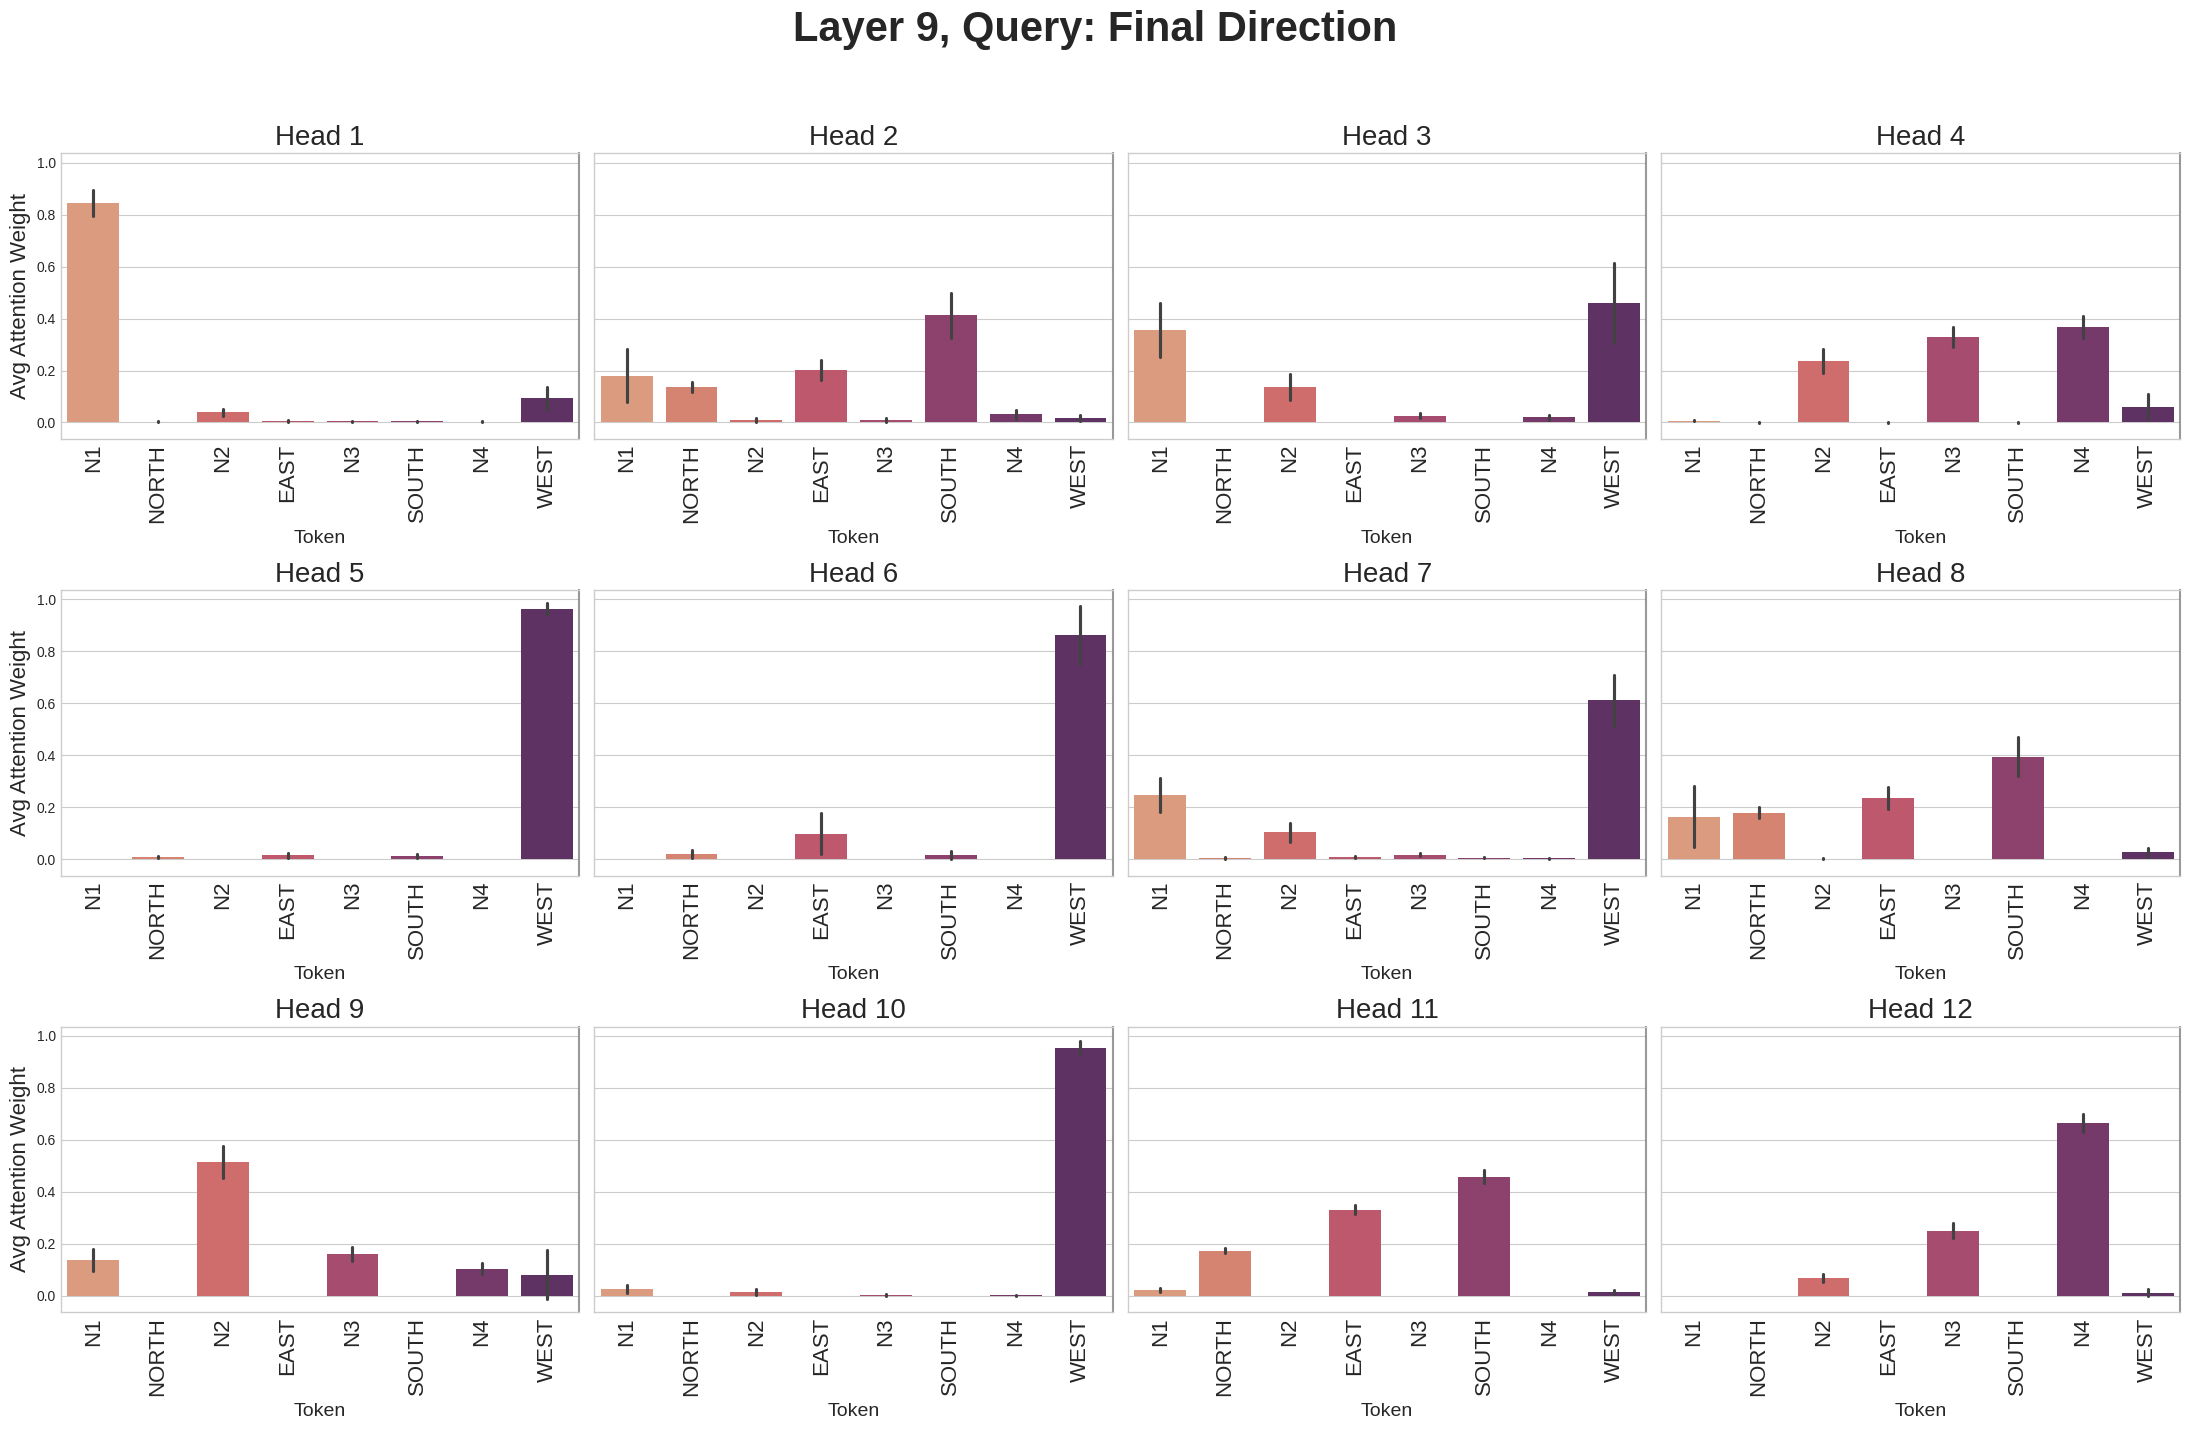

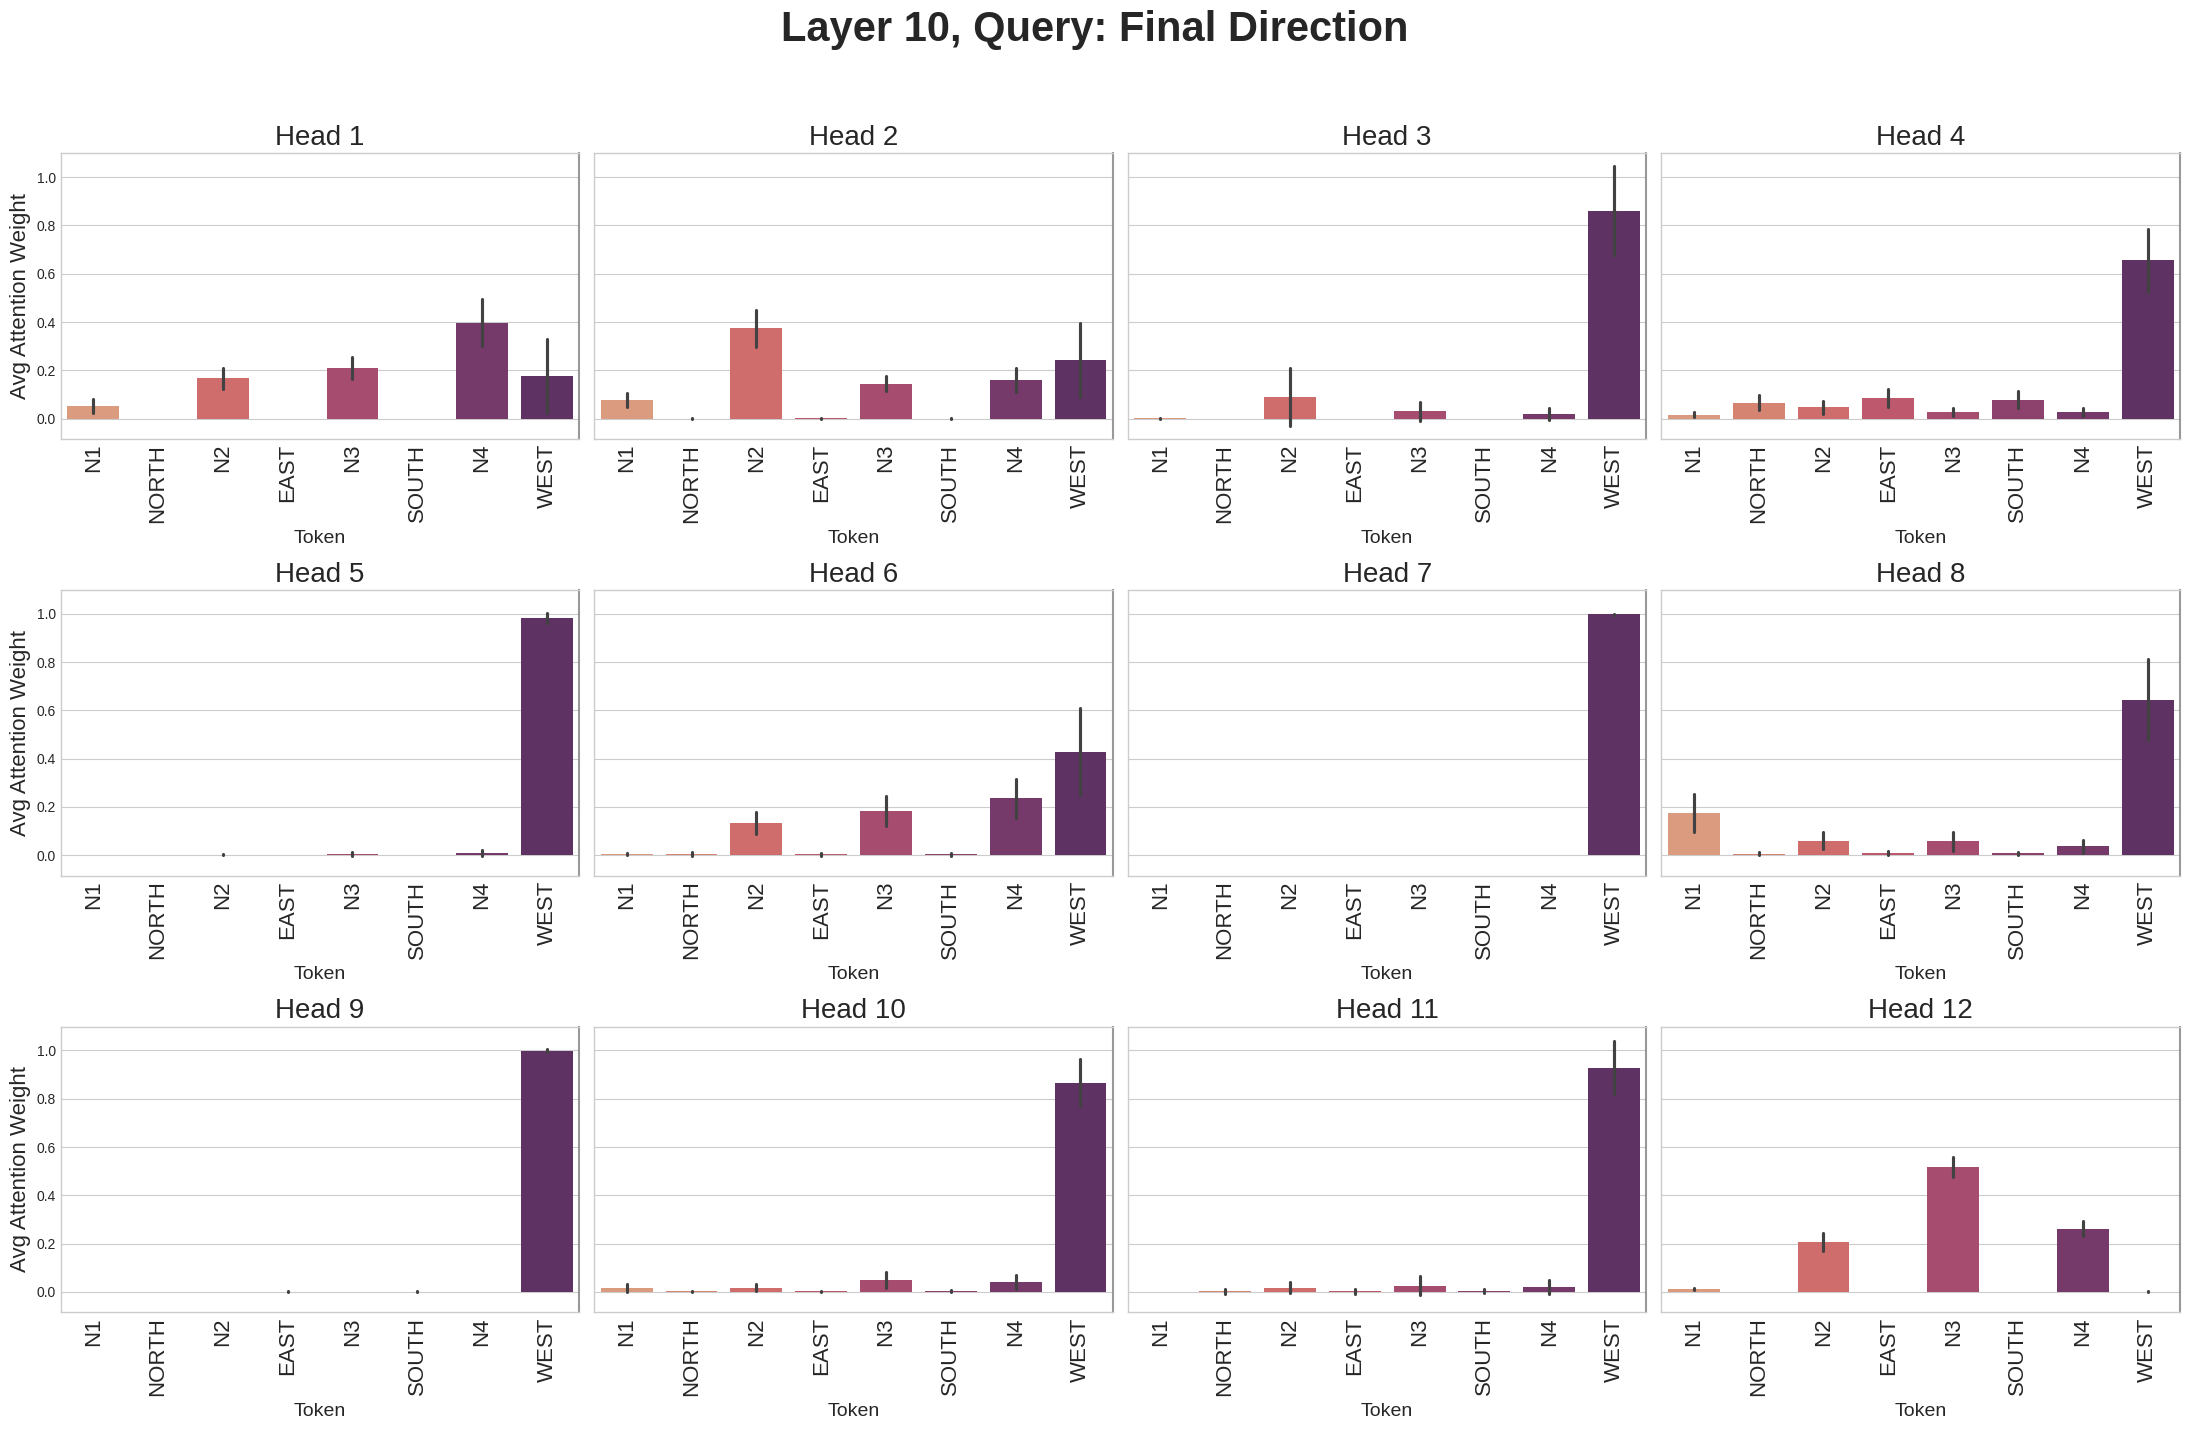

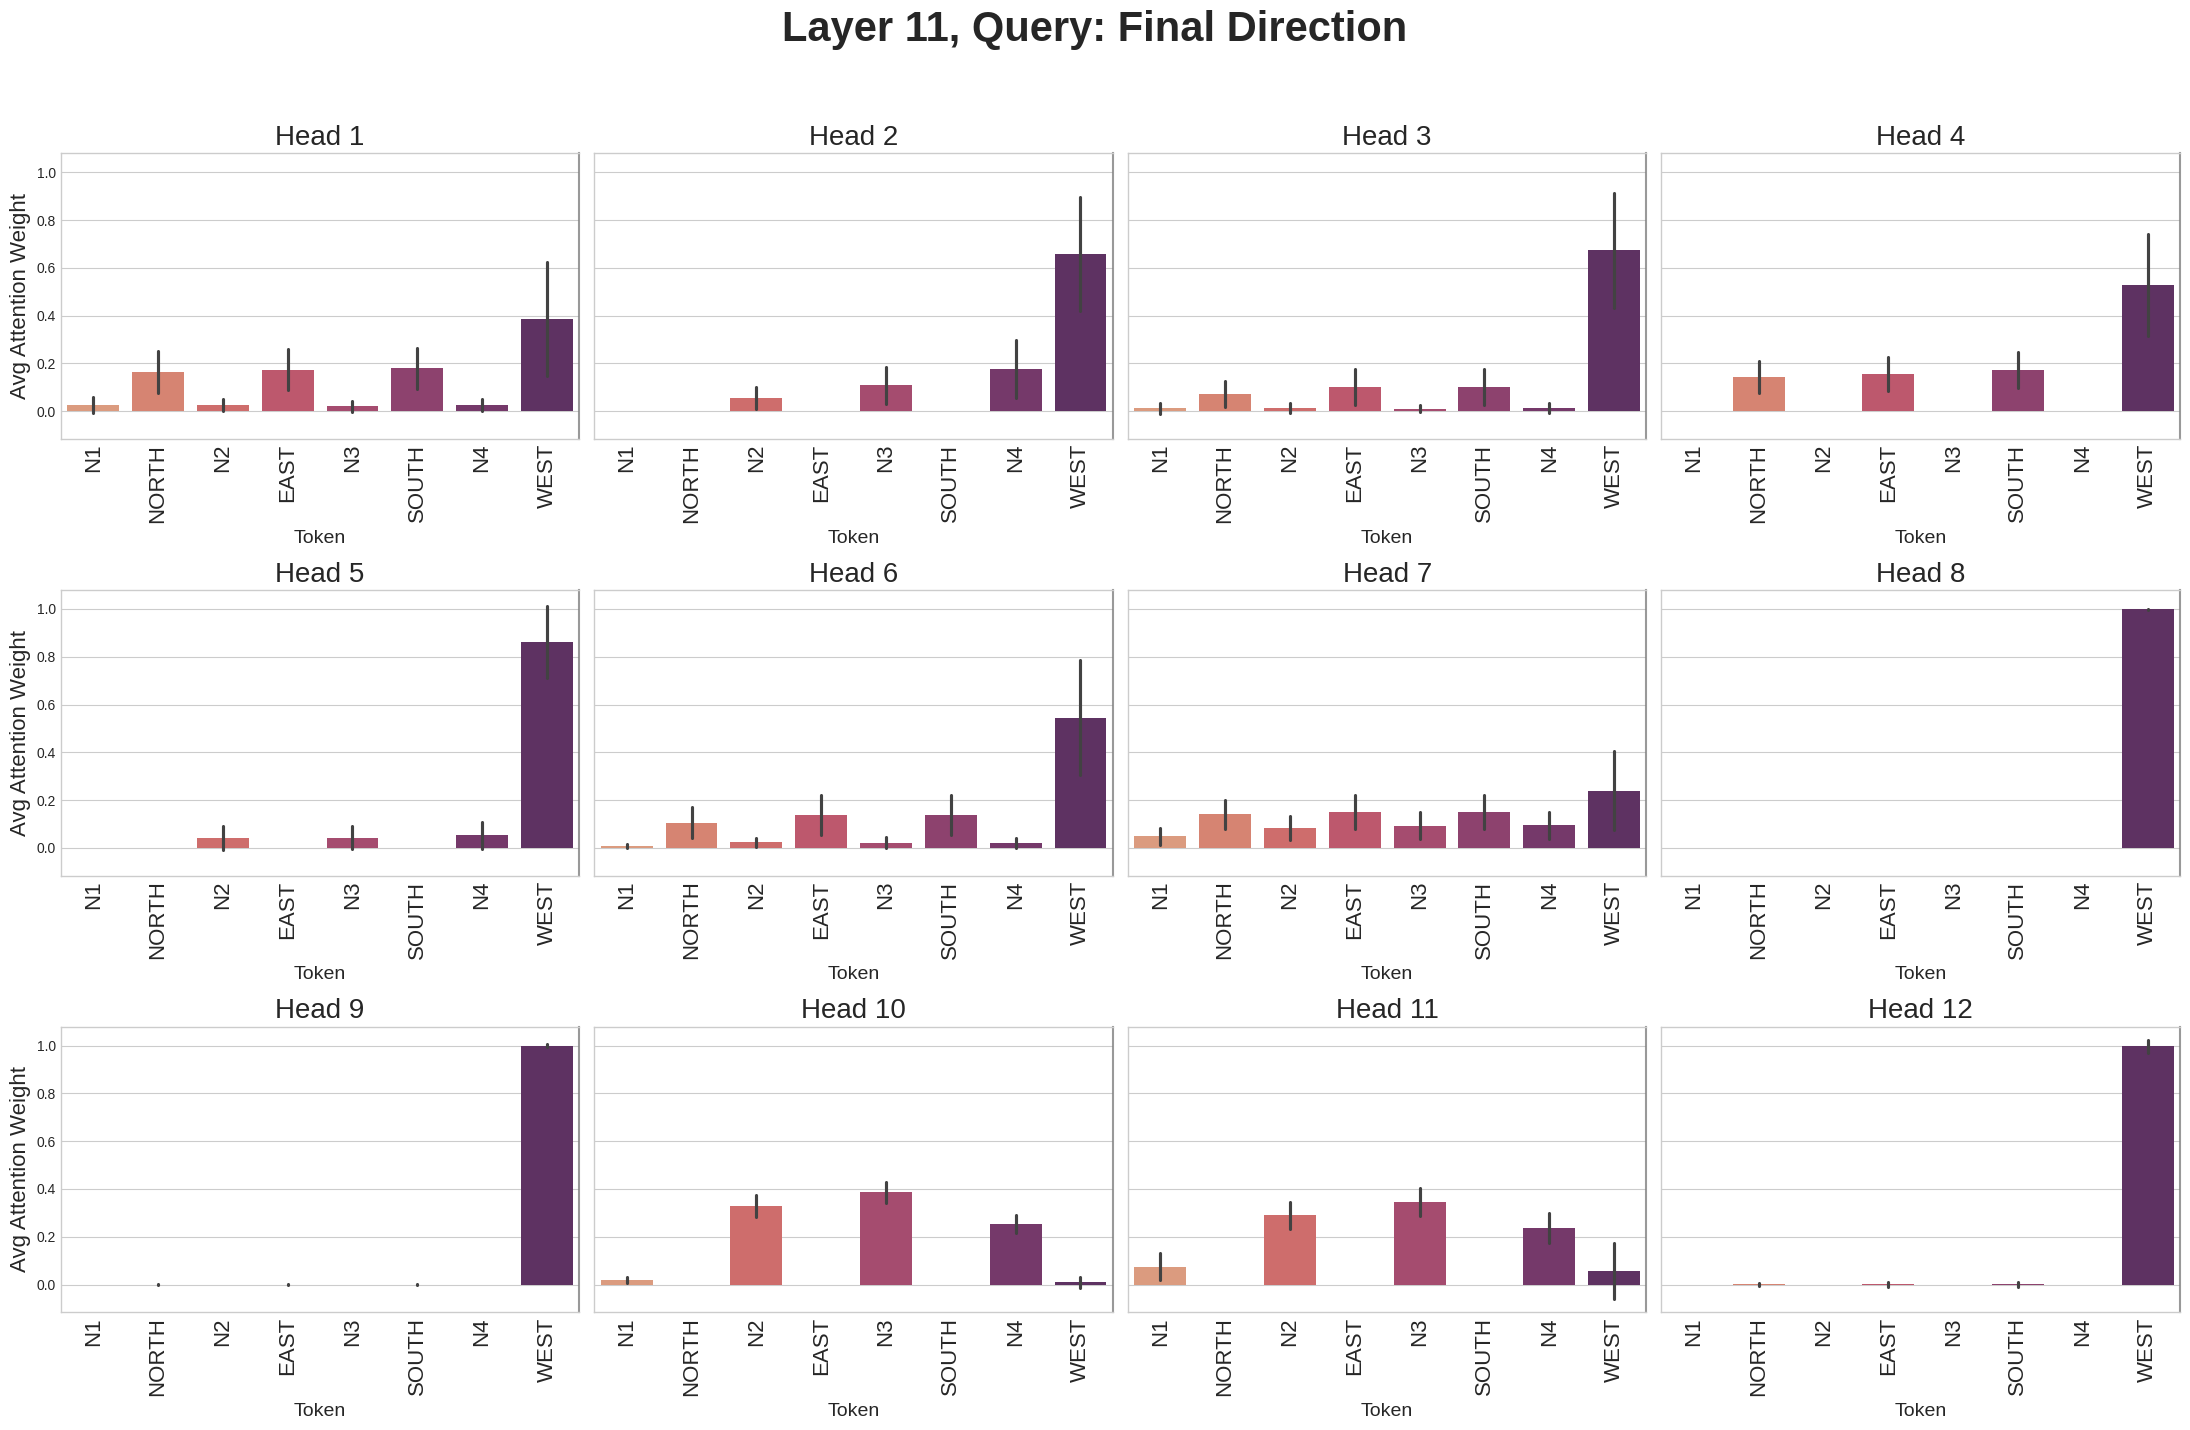

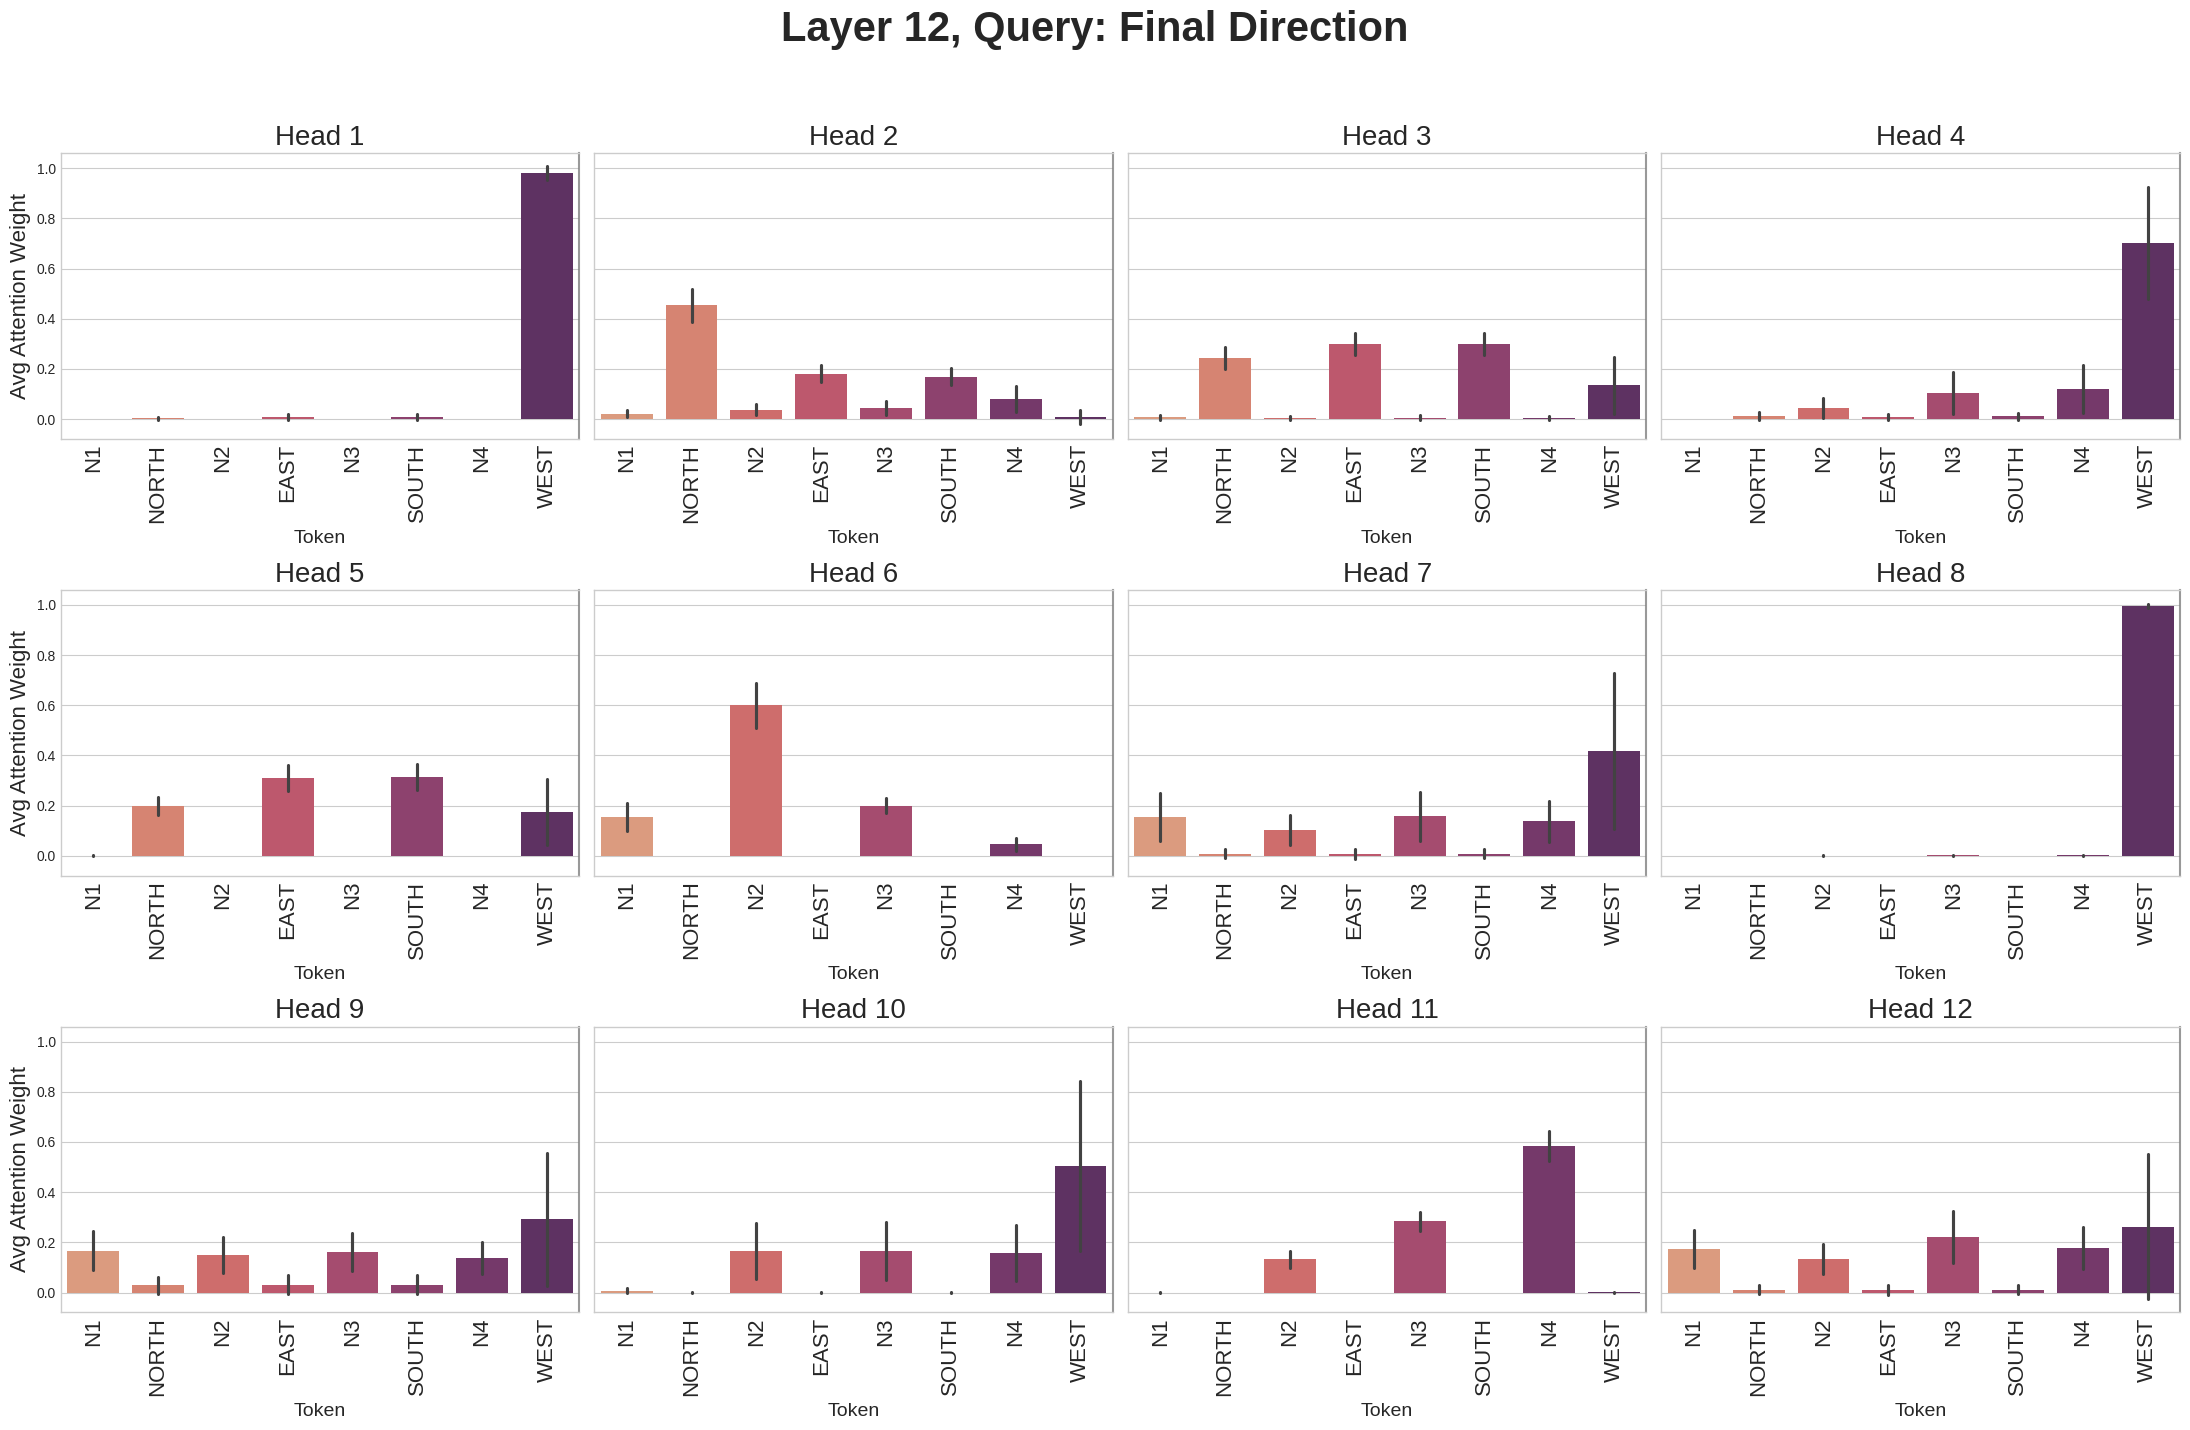

In [7]:
# Layer 1 Aggregated Attention Analysis Across All Path Templates 

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from tqdm import tqdm
import pandas as pd


NUM_TRIALS = 1000
NUM_LAYERS = model.config.n_layer
NUM_HEADS = model.config.n_head

QUERY_FINAL_NODE = False

PATH_TEMPLATES = {
    # "S-E-N-W": "{} SOUTH {} EAST {} NORTH {} WEST",
    "N-E-S-W": "{} NORTH {} EAST {} SOUTH {} WEST",
    # "E-N-W-S": "{} EAST {} NORTH {} WEST {} SOUTH",
    # "W-N-E-S": "{} WEST {} NORTH {} EAST {} SOUTH",
    # "W-S-E-N": "{} WEST {} SOUTH {} EAST {} NORTH",
    # "E-S-W-N": "{} EAST {} SOUTH {} WEST {} NORTH",
    # "N-W-S-E": "{} NORTH {} WEST {} SOUTH {} EAST",
    # "S-W-N-E": "{} SOUTH {} WEST {} NORTH {} EAST",
}


# --- Pre-computation and Validation (EDITED) ---
template_lengths = {name: len(template.split()) for name, template in PATH_TEMPLATES.items()}
first_length = next(iter(template_lengths.values()))
assert all(length == first_length for length in template_lengths.values()), \
    "All path templates must have the same sequence length for aggregation."

# Adjust sequence length based on whether we add the final node
SEQUENCE_LENGTH = first_length
if QUERY_FINAL_NODE:
    SEQUENCE_LENGTH += 1

NUM_TEMPLATES = len(PATH_TEMPLATES)
TOTAL_TRIALS = NUM_TRIALS * NUM_TEMPLATES

# --- Helper Functions (EDITED) ---

def generate_random_nodes(count: int) -> list[str]:
    """Generates a list of unique, random 2-letter node names."""
    nodes = set()
    while len(nodes) < count:
        node = ''.join(random.choice(string.ascii_lowercase) for _ in range(2))
        nodes.add(node)
    return list(nodes)

def get_relative_labels_from_template(template: str, is_completed_loop: bool) -> list[str]: # EDITED
    """Creates generic, relative labels for the x-axis from a template string."""
    parts = template.split()
    labels = []
    node_idx = 1
    dir_idx = 1
    for part in parts:
        if part == '{}':
            labels.append(f"N{node_idx}")
            node_idx += 1
        else:
            labels.append(part) # Using actual direction names for clarity
            dir_idx += 1
            
    # NEW: Add the label for the final, repeated node if applicable
    if is_completed_loop:
        labels.append("N1 (end)")
        
    return labels


def plot_aggregated_patterns(attention_data, relative_labels, title_info, layer_idx, query_description: str): # EDITED
    """
    Plots the mean attention with standard deviation error bars for all heads in a given Layer.
    """
    num_trials = attention_data.shape[2]
    num_heads = attention_data.shape[1]
    seq_len = attention_data.shape[3]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 4, figsize=(22, 15), sharey=True)
    axes = np.array(axes).flatten()
    palette = sns.color_palette("flare", n_colors=seq_len)

    # EDITED: Main title is now more descriptive
    main_title = (
        # f"Layer {layer_idx+1} Aggregated Attention ({title_info})\n"
        # f"({query_description}, N={num_trials} total trials)"
        f"Layer {layer_idx+1}, {query_description}"
    )
    fig.suptitle(main_title, fontsize=30, weight='bold')

    layer_data = attention_data[layer_idx, :, :, :]

    for head_idx in range(num_heads):
        ax = axes[head_idx]
        head_data = layer_data[head_idx, :, :]
        df = pd.DataFrame(head_data, columns=relative_labels)
        df_long = df.melt(var_name='Position', value_name='Attention')

        sns.barplot(
            x='Position', y='Attention', data=df_long, ax=ax,
            hue='Position', palette=palette, errorbar='sd',
            dodge=False, legend=False
        )

        ax.set_title(f"Head {head_idx + 1}", fontsize=20)
        ax.tick_params(axis='x', labelrotation=90, labelsize=16)
        ax.set_xlabel("Token", fontsize=14, labelpad=5)
        if head_idx % 4 == 0:
            ax.set_ylabel("Avg Attention Weight", fontsize=16)
        # Make the right spine thicker and darker
        ax.spines['right'].set_linewidth(1.5)
        ax.spines['right'].set_color('gray')
        ax.spines['right'].set_alpha(0.8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Main Execution: Data Collection (EDITED) ---

attention_data = np.zeros((NUM_LAYERS, NUM_HEADS, TOTAL_TRIALS, SEQUENCE_LENGTH))

print(f"Aggregating data across {NUM_TEMPLATES} templates ({NUM_TRIALS} trials each)...")
print(f"Total trials to run: {TOTAL_TRIALS}")

global_trial_idx = 0
for template_name, template in PATH_TEMPLATES.items():
    print(f"\n--- Processing Template: '{template_name}' ---")
    
    num_nodes_needed = template.count('{}')
    
    for _ in tqdm(range(NUM_TRIALS)):
        nodes = generate_random_nodes(num_nodes_needed)
        
        # EDITED: Conditionally generate the prompt
        if QUERY_FINAL_NODE:
            # Create a completed loop by appending the first node
            prompt = template.format(*nodes) + f" {nodes[0]}"
        else:
            # Original behavior
            prompt = template.format(*nodes)

        tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        if tokens.input_ids.shape[1] != SEQUENCE_LENGTH:
            continue
        
        with torch.no_grad():
            outputs = model(**tokens, output_attentions=True)
            
        query_pos = -1 # Always query the last token in the sequence
        for layer_idx in range(NUM_LAYERS):
            layer_attentions = outputs.attentions[layer_idx].cpu().squeeze(0)
            for head_idx in range(NUM_HEADS):
                attention_vector = layer_attentions[head_idx, query_pos, :].numpy()
                attention_data[layer_idx, head_idx, global_trial_idx, :] = attention_vector
        
        global_trial_idx += 1

if global_trial_idx < TOTAL_TRIALS:
    print(f"Warning: {TOTAL_TRIALS - global_trial_idx} trials were skipped due to tokenization length mismatch.")
    attention_data = attention_data[:, :, :global_trial_idx, :]


print(f"\n\n{'='*30} PLOTTING AGGREGATED RESULTS {'='*30}")

first_template = next(iter(PATH_TEMPLATES.values()))

relative_labels = get_relative_labels_from_template(first_template, is_completed_loop=QUERY_FINAL_NODE)

title_info = "All 4-Hop Loop Templates"
if QUERY_FINAL_NODE:
    query_description = "Query: Final Node"
else:
    query_description = "Query: Final Direction"

for layer in range(0,12):
    plot_aggregated_patterns(attention_data, relative_labels, title_info, layer_idx=layer, query_description=query_description)
# plot_aggregated_patterns(attention_data, relative_labels, title_info, layer_idx=0, query_description=query_description)
# plot_aggregated_patterns(attention_data, relative_labels, title_info, layer_idx=9, query_description=query_description)
# # ...

In [25]:
# Head Redundancy Analysis for Cross-Context Patching
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

def test_head_combinations(model, tokenizer, num_test_cases=100, min_success_rate=0.8):
    """Test different head combinations across multiple test cases for robust redundancy analysis."""
    TARGET_LAYER = 0
    num_heads = model.config.n_head
    head_dim = model.config.n_embd // num_heads
    
    print("="*70)
    print("ROBUST HEAD REDUNDANCY ANALYSIS: CROSS-CONTEXT PATCHING")
    print(f"Testing across {num_test_cases} test cases with {min_success_rate*100}% success threshold")
    print("="*70)
    
    # Generate multiple test cases
    test_cases = []
    print("Generating test cases (showing first 5)...")
    for i in range(num_test_cases):
        try:
            test_case = generate_independent_test_case()
            test_cases.append(test_case)
            if i < 5:
                print(f"Test case {i+1}: {test_case['direction_A']} -> {test_case['expected_outcome_A']}")
        except Exception as e:
            if i < 5:
                print(f"Failed to generate test case {i+1}: {e}")
            continue
    
    if len(test_cases) < 3:
        print("Need at least 3 test cases for robust analysis!")
        return
    
    print(f"\nGenerated {len(test_cases)} valid test cases")
    print("="*70)

    successful_combinations = []
    
    for size in range(1, num_heads + 1):
        print(f"\nTesting {size}-head combinations...")
        size_successful = []
        
        all_combos = list(itertools.combinations(range(num_heads), size))
        
        for combo in tqdm(all_combos, desc=f"Testing {size}-head combinations", leave=False):
            heads_to_patch = list(combo)
            successes = 0
            total_tests = 0
            
            for test_case in test_cases:
                try:
                    donor_tokens = tokenizer(test_case["prompt_A"], return_tensors="pt").to(DEVICE)
                    donor_direction_pos = find_token_position(donor_tokens, test_case["direction_A"], tokenizer)
                    
                    attn_outputs_cache = []
                    hook = model.transformer.h[TARGET_LAYER].attn.register_forward_hook(
                        lambda _, __, output: attn_outputs_cache.append(output[0])
                    )
                    with torch.no_grad():
                        model(**donor_tokens)
                    hook.remove()
                    donor_attn_output = attn_outputs_cache[0]
                    
                    combined_patch = torch.zeros_like(donor_attn_output)
                    for head_idx in heads_to_patch:
                        start_idx = head_idx * head_dim
                        end_idx = (head_idx + 1) * head_dim
                        head_output = donor_attn_output[:, :, start_idx:end_idx].detach()
                        combined_patch[:, :, start_idx:end_idx] = head_output
                    
                    patch_vector = combined_patch[0, donor_direction_pos, :].detach()
                    
                    recipient_tokens = tokenizer(test_case["prompt_B"], return_tensors="pt").to(DEVICE)
                    recipient_direction_pos = find_token_position(recipient_tokens, test_case["direction_B"], tokenizer)
                    
                    with ComponentPatcher(model, TARGET_LAYER, 'attention', patch_vector, recipient_direction_pos):
                        with torch.no_grad():
                            patched_outputs = model(**recipient_tokens)
                    
                    patched_logits = patched_outputs.logits[0, recipient_direction_pos, :]
                    predicted_token = tokenizer.decode(torch.argmax(patched_logits).item()).strip()
                    
                    if predicted_token == test_case['expected_outcome_A']:
                        successes += 1
                    total_tests += 1
                    
                    del donor_tokens, recipient_tokens, donor_attn_output, combined_patch, patch_vector
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        
                except Exception as e:
                    continue
            
            if total_tests > 0:
                success_rate = successes / total_tests
                if success_rate >= min_success_rate:
                    size_successful.append({
                        'combination': combo,
                        'size': size,
                        'success_rate': success_rate,
                        'successes': successes,
                        'total_tests': total_tests
                    })
        
        if size_successful:
            successful_combinations.extend(size_successful)
            print(f"Found {len(size_successful)} successful {size}-head combinations")
            break
        else:
            print(f"No successful {size}-head combinations found")
    
    if not successful_combinations:
        print("No successful combinations found!")
        return
    
    min_size = min(combo['size'] for combo in successful_combinations)
    minimal_combinations = [combo for combo in successful_combinations if combo['size'] == min_size]
    
    print(f"\n" + "="*70)
    print("REDUNDANCY ANALYSIS RESULTS")
    print("="*70)
    print(f"Minimum heads needed: {min_size}")
    print(f"Minimal combinations: {len(minimal_combinations)}")
    print(f"Test cases used: {len(test_cases)}")
    
    total_possible = len(list(itertools.combinations(range(num_heads), min_size)))
    redundancy_ratio = len(minimal_combinations) / total_possible
    
    print(f"Redundancy ratio: {redundancy_ratio:.3f}")
    print(f"({len(minimal_combinations)} out of {total_possible} possible combinations work)")
    
    print(f"\nSuccessful combinations (with success rates):")
    for i, combo in enumerate(minimal_combinations[:10]):
        combo_1_indexed = tuple(h + 1 for h in combo['combination'])
        print(f"  {i+1}. {combo_1_indexed} (rate: {combo['success_rate']:.3f}, {combo['successes']}/{combo['total_tests']})")
    if len(minimal_combinations) > 10:
        print(f"  ... and {len(minimal_combinations) - 10} more")
    
    head_counts = Counter()
    for combo in minimal_combinations:
        for head in combo['combination']:
            head_counts[head] += 1
    
    print(f"\nHead frequency in successful combinations:")
    for head, count in sorted(head_counts.items()):
        print(f"  Head {head + 1}: {count} times")
    
    if minimal_combinations:
        if min_size == 1:
            # If we only have 1-head combinations, a single bar chart of success rates is best.
            print("\nVisualizing success rates of individual specialist heads...")
            
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # Prepare data for the plot
            plot_data = sorted(minimal_combinations, key=lambda x: x['combination'])
            labels = [f"H{c['combination'][0] + 1}" for c in plot_data]
            rates = [c['success_rate'] for c in plot_data]
            
            bars = sns.barplot(x=labels, y=rates, ax=ax, palette='viridis')
            #ax.set_title('Success Rate of Individual Heads', fontsize=16)
            ax.set_xlabel('Attention Head in Layer 1', fontsize=12)
            ax.set_ylabel('Success Rate', fontsize=12)
            ax.set_ylim(0, 1.05)
            
            # Add the success threshold line
            ax.axhline(min_success_rate, color='red', linestyle='--', label=f'Success Threshold ({min_success_rate})')
            ax.legend()
            
            # Add text labels on top of each bar
            for bar in bars.patches:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        bar.get_height(),
                        f'{bar.get_height():.2%}',
                        ha='center', va='bottom',
                        fontsize=11)
            
            plt.tight_layout()
            plt.show()

        else:
            # If minimal size > 1, the original two-plot layout is more informative.
            print("\nVisualizing frequency and distribution for multi-head circuits...")
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            sorted_heads_0_indexed = sorted(head_counts.keys())
            labels_1_indexed = [f"H{h+1}" for h in sorted_heads_0_indexed]
            frequencies = [head_counts[h] for h in sorted_heads_0_indexed]
            
            ax1.bar(labels_1_indexed, frequencies)
            ax1.set_xlabel('Head Index (1-12)')
            ax1.set_ylabel('Frequency in Successful Combinations')
            ax1.set_title(f'Head Importance in {min_size}-Head Combinations')
            
            success_rates = [combo['success_rate'] for combo in minimal_combinations]
            ax2.hist(success_rates, bins=10, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Success Rate')
            ax2.set_ylabel('Number of Combinations')
            ax2.set_title('Distribution of Success Rates')
            ax2.axvline(min_success_rate, color='red', linestyle='--', label=f'Threshold ({min_success_rate})')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    return successful_combinations, minimal_combinations

# Execute robust analysis
results = test_head_combinations(model, tokenizer, num_test_cases=1000, min_success_rate=0.6)

ROBUST HEAD REDUNDANCY ANALYSIS: CROSS-CONTEXT PATCHING
Testing across 1000 test cases with 60.0% success threshold
Generating test cases (showing first 5)...
Test case 1: WEST -> cv
Test case 2: WEST -> rg
Test case 3: WEST -> ox
Test case 4: WEST -> fr
Test case 5: WEST -> ey



Generated 1000 valid test cases

Testing 1-head combinations...


KeyboardInterrupt: 

Generating test cases...
Calculating baseline...
Baseline: 1.000
Testing 1-layer ablations...


Testing 2-layer ablations...


Testing 3-layer ablations...


Testing 4-layer ablations...


Testing 5-layer ablations...


Testing 6-layer ablations...


Testing 7-layer ablations...


Testing 8-layer ablations...


Testing 9-layer ablations...


Testing 10-layer ablations...


Testing 11-layer ablations...


/tmp/ipykernel_200151/1058388706.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='layers_ablated', y='accuracy', data=results_df, palette='viridis')


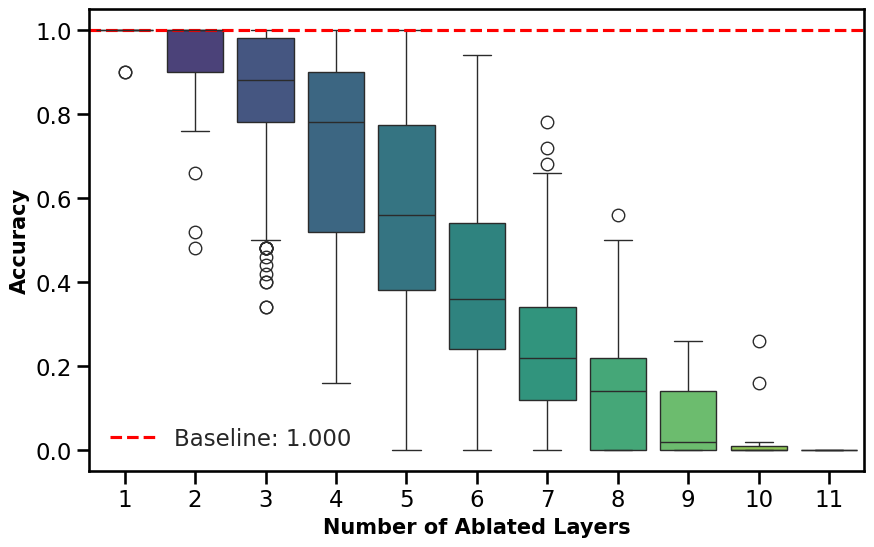


Breaking point: 3 layers
Minimal required: 9 layers


In [ ]:
# Layer Ablation Analysis: Testing Layer Redundancy

import itertools
from contextlib import ExitStack
import matplotlib.pyplot as plt
import seaborn as sns

def run_layer_ablation_analysis(model, tokenizer, num_test_cases=50):
    """Test all combinations of layer ablation to find minimal required layers."""
    print("Generating test cases...")
    test_cases = [generate_minimal_pair_case() for _ in range(num_test_cases)]
    
    # Get baseline accuracy
    print("Calculating baseline...")
    correct = 0
    with torch.no_grad():
        for case in test_cases:
            tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
            logits = model(**tokens).logits
            pred = tokenizer.decode(torch.argmax(logits[0, -1, :]).item()).strip()
            if pred == case['expected_clean_prediction']:
                correct += 1
    baseline = correct / num_test_cases
    print(f"Baseline: {baseline:.3f}")

    # Test all layer combinations
    all_layers = list(range(1, model.config.n_layer))  # Skip Layer 0
    results = []
    
    for k in range(1, len(all_layers) + 1):
        print(f"Testing {k}-layer ablations...")
        combinations = list(itertools.combinations(all_layers, k))
        
        for combo in tqdm(combinations, leave=False):
            correct = 0
            
            with ExitStack() as stack:
                for layer_idx in combo:
                    stack.enter_context(AblationPatcher(model, layer_idx))
                
                with torch.no_grad():
                    for case in test_cases:
                        tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
                        logits = model(**tokens).logits
                        pred = tokenizer.decode(torch.argmax(logits[0, -1, :]).item()).strip()
                        if pred == case['expected_clean_prediction']:
                            correct += 1
            
            accuracy = correct / num_test_cases
            results.append({
                "layers_ablated": k,
                "ablated_layers": combo,
                "accuracy": accuracy
            })
    
    # Analyze results
    results_df = pd.DataFrame(results)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='layers_ablated', y='accuracy', data=results_df, palette='viridis')
    plt.axhline(baseline, color='red', linestyle='--', label=f'Baseline: {baseline:.3f}')
    plt.xlabel('Number of Ablated Layers', fontsize=15, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=15, fontweight='bold')
    #plt.title('Model Performance vs Number of Ablated Layers')
    plt.legend()
    plt.show()
    
    # Find breaking point
    avg_by_k = results_df.groupby('layers_ablated')['accuracy'].mean()
    breaking_point = 0
    for k, avg_acc in avg_by_k.items():
        if avg_acc < 0.9 * baseline:
            breaking_point = k
            break
    
    print(f"\nBreaking point: {breaking_point} layers")
    print(f"Minimal required: {len(all_layers) - breaking_point + 1} layers")
    
    return results_df

# Execute analysis
layer_results = run_layer_ablation_analysis(model, tokenizer, num_test_cases=50)

Generating 500 test cases...


Generating Cases: 100%|██████████| 500/500 [00:00<00:00, 8226.09it/s]

Calculating baseline performance (no ablation)...


Baseline Accuracy: 100.00%


Ablating Layers: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]


--- Single-Layer Ablation Results ---
 Layer  Accuracy
     1    0.0020
     2    0.9880
     3    0.9540
     4    0.9720
     5    0.9980
     6    0.9980
     7    1.0000
     8    1.0000
     9    1.0000
    10    1.0000
    11    1.0000
    12    1.0000


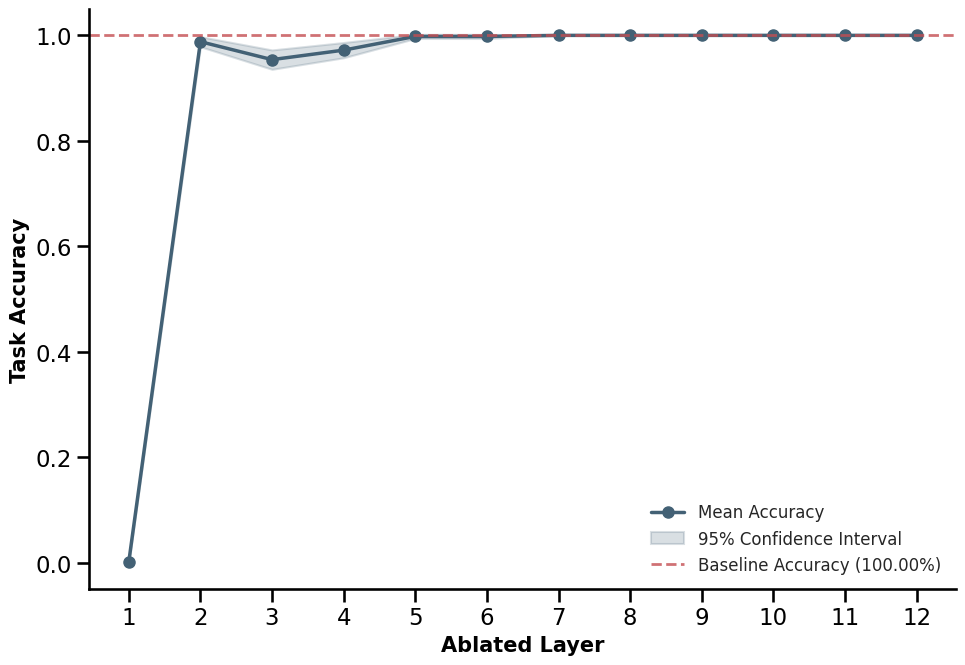

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure all the necessary helper functions and classes are available
# (generate_minimal_pair_case, AblationPatcher, model, tokenizer, DEVICE)

def plot_ablation_line_chart(results_df, baseline_accuracy, num_test_cases):
    """
    Plots the single-layer ablation results as a line plot with confidence intervals,
    matching the specified academic format.
    """
    # 1. Apply the specified plotting style
    plt.rcParams.update({
        "axes.edgecolor": "black", "axes.linewidth": 2, "xtick.color": "black",
        "ytick.color": "black", "axes.labelcolor": "black", "xtick.major.width": 2,
        "ytick.major.width": 2, "xtick.major.size": 7, "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black", "axes.labelcolor": "black",
        "xtick.color": "black", "ytick.color": "black",
    })

    # 2. Prepare data for plotting
    num_layers = len(results_df)
    layers = results_df['Layer'].values
    accuracies = results_df['Accuracy'].values

    # Calculate the 95% confidence interval for a binomial proportion
    # CI = 1.96 * sqrt(p*(1-p)/n)
    confidence_interval = 1.96 * np.sqrt(accuracies * (1 - accuracies) / num_test_cases)

    # 3. Create the plot
    plt.figure(figsize=(10, 7))
    
    # Plot the mean accuracy line
    plt.plot(layers, accuracies, marker='o', linestyle='-', color='#436175', 
             label='Mean Accuracy', linewidth=2.5, markersize=8)
             
    # Add the shaded confidence interval region
    plt.fill_between(layers, accuracies - confidence_interval, accuracies + confidence_interval, 
                     color='#436175', alpha=0.2, label='95% Confidence Interval')
                     
    # Add the baseline accuracy reference line
    plt.axhline(baseline_accuracy, color='r', linestyle='--', alpha=0.8, 
                label=f'Baseline Accuracy ({baseline_accuracy:.2%})', linewidth=2)
    
    # 4. Format the plot with titles, labels, and ticks
    plt.xlabel('Ablated Layer', fontsize=15, fontweight="heavy")
    plt.ylabel('Task Accuracy', fontsize=15, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1))
    plt.yticks(np.linspace(0, 1, 6)) # Ticks from 0.0, 0.2, ..., 1.0
    plt.ylim(-0.05, 1.05)
    
    sns.despine() # Remove top and right plot borders
    plt.grid(False) # Turn off the grid
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


def run_single_layer_ablation(model, tokenizer, num_test_cases=200):
    """
    Ablates each layer of the model individually, measures performance,
    and visualizes the results with a line plot.
    """
    print(f"Generating {num_test_cases} test cases...")
    test_cases = [generate_minimal_pair_case() for _ in tqdm(range(num_test_cases), desc="Generating Cases")]

    print("Calculating baseline performance (no ablation)...")
    baseline_correct = 0
    with torch.no_grad():
        for case in test_cases:
            tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
            logits = model(**tokens).logits
            predicted_id = torch.argmax(logits[0, -1, :]).item()
            predicted_token = tokenizer.decode(predicted_id).strip()
            if predicted_token == case['expected_clean_prediction']:
                baseline_correct += 1
    
    baseline_accuracy = baseline_correct / num_test_cases
    print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

    results = []
    all_layers = range(model.config.n_layer)

    for layer_idx in tqdm(all_layers, desc="Ablating Layers"):
        correct_predictions = 0
        with AblationPatcher(model, layer_idx):
            with torch.no_grad():
                for case in test_cases:
                    tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
                    logits = model(**tokens).logits
                    predicted_id = torch.argmax(logits[0, -1, :]).item()
                    predicted_token = tokenizer.decode(predicted_id).strip()
                    if predicted_token == case['expected_clean_prediction']:
                        correct_predictions += 1
        
        accuracy = correct_predictions / num_test_cases
        results.append({
            'Layer': layer_idx + 1,  # Use 1-based indexing
            'Accuracy': accuracy
        })

    results_df = pd.DataFrame(results)
    
    print("\n--- Single-Layer Ablation Results ---")
    print(results_df.to_string(index=False, float_format="%.4f"))
    
    # Call the new plotting function
    plot_ablation_line_chart(results_df, baseline_accuracy, num_test_cases)
    
    return results_df

# --- Run the experiment ---
single_layer_ablation_results = run_single_layer_ablation(model, tokenizer, num_test_cases=500)